In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py as h5
import ytree
import yt
import cPickle as pickle
import os
import math

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from matplotlib import rc, rcParams
rc('font', size=18)
rc('xtick', direction='in')
rc('ytick', direction='in')

# Read halo merger trees

In [3]:
trees = ytree.load('rockstar_halos/trees/tree_0_0_0.dat')
trees.add_alias_field('mass', 'Mvir')

ytree: [WARNING  ] 2018-03-12 12:49:06,902 Overriding field "mass" that already exists as alias field.


Performance will be improved by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("rockstar_halos/trees/tree_0_0_0.dat")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)


In [20]:
mrange = [1e8, 1e10]
halo_mmp = []
for tree in trees:
    if tree['mass'].in_units('Msun') < mrange[0] or tree['mass'].in_units('Msun') > mrange[1]:
        continue
    mmp = dict(center=[], mass=[], redshift=[], rvir=[])
    for prog in tree.pwalk():
        pos = yt.YTArray([prog['x'], prog['y'], prog['z']]) / trees.box_size
        mmp['center'].append(pos)
        mmp['mass'].append(prog['mass'].in_units('Msun'))
        mmp['redshift'].append(prog['redshift'])
        mmp['rvir'].append(prog['virial_radius'] / trees.box_size)
    mmp['center'] = yt.YTArray(mmp['center'])
    mmp['mass'] = yt.YTArray(mmp['mass'])
    mmp['redshift'] = yt.YTArray(mmp['redshift'])
    mmp['rvir'] = yt.YTArray(mmp['rvir'])
    halo_mmp.append(mmp)

In [21]:
print halo_mmp[0]['rvir']

[0.00117553 0.00114285 0.00115123 0.00113472 0.001115   0.00105993
 0.00105109 0.00101106 0.00101176 0.00099148 0.00096813 0.00097018
 0.00095859 0.00094285 0.00093423 0.00091345 0.00089472 0.00088908
 0.00087838 0.00082602 0.00085542 0.00083447 0.00081053 0.00078923
 0.00076535 0.00075092 0.00074046 0.00073264 0.00072585 0.00071711
 0.00070856 0.00069831 0.00069018 0.00067796 0.00066359 0.00064204
 0.00057768 0.00060849 0.00059327 0.00058268 0.00056789 0.00055511
 0.00052958 0.00052246 0.00051842 0.00050585 0.00049102 0.00047739
 0.00046254 0.00044771 0.00043873 0.00042546 0.00041222 0.00039923
 0.0003918  0.00038482 0.00037891 0.00037116 0.00036518 0.00035806
 0.0003513  0.00034229 0.00033331 0.00032986 0.00032356 0.00030423
 0.00028493 0.00025792 0.00023933] dimensionless


# Read simulation redshifts

In [6]:
pfn = []
redshifts = []
if os.path.exists('redshifts.dat'):
    lines = open('redshifts.dat').readlines()
    for l in lines:
        pfn.append(l.split(':')[0])
        redshifts.append(float(l.split('=')[-1]))
else:
    ts = yt.DatasetSeries('DD????/output_????')
    for ds in ts:
        redshifts.append(ds.current_redshift)
        pfn.append(ds.parameter_filename)
    
redshifts = np.array(redshifts)
pfn = np.array(pfn)
isort = redshifts.argsort().astype('int')[::-1]
redshifts = redshifts[isort]
pfn = pfn[isort]

# Read halo properties

In [22]:
print halo_mmp[0]['rvir']

[0.00117553 0.00114285 0.00115123 0.00113472 0.001115   0.00105993
 0.00105109 0.00101106 0.00101176 0.00099148 0.00096813 0.00097018
 0.00095859 0.00094285 0.00093423 0.00091345 0.00089472 0.00088908
 0.00087838 0.00082602 0.00085542 0.00083447 0.00081053 0.00078923
 0.00076535 0.00075092 0.00074046 0.00073264 0.00072585 0.00071711
 0.00070856 0.00069831 0.00069018 0.00067796 0.00066359 0.00064204
 0.00057768 0.00060849 0.00059327 0.00058268 0.00056789 0.00055511
 0.00052958 0.00052246 0.00051842 0.00050585 0.00049102 0.00047739
 0.00046254 0.00044771 0.00043873 0.00042546 0.00041222 0.00039923
 0.0003918  0.00038482 0.00037891 0.00037116 0.00036518 0.00035806
 0.0003513  0.00034229 0.00033331 0.00032986 0.00032356 0.00030423
 0.00028493 0.00025792 0.00023933] dimensionless


In [23]:
pfile = 'fesc.cpkl'
if os.path.exists(pfile):
    fp = open(pfile, 'rb')
    catalog = pickle.load(fp)
    fp.close()
else:
    catalog = []
    for fn in pfn:
        entry = {}
        fp = h5.File('fesc-data/p%s_fesc_halos.h5' % (fn.split('/')[1]), 'r')
        nhalos = len(fp.keys())
        if nhalos == 0:
            catalog.append(entry)
            fp.close()
            continue
        gp0 = fp.values()[0]
        avoid = ['Pop2_Stars', 'Pop3_Stars', 'fesc_bins', 'fesc_hist']
        vector_fields = ['center']
        # Create empty entry
        for f in gp0:
            if f not in avoid:
                if f in vector_fields:
                    entry[f] = np.zeros((nhalos,3))
                else:
                    entry[f] = np.zeros(nhalos)
        # Read the data
        i = 0
        for g in fp.itervalues():
            for f in g:
                if f not in avoid:
                    entry[f][i] = g[f].value
            i += 1
        catalog.append(entry)
        fp.close()
    # Serialize properties
    fp = open(pfile, 'wb')
    pickle.dump(catalog, fp)
    fp.close()

# Link halo properties to merger tree nodes

In [24]:
def find_nearest(array, value):
    return np.abs(array - value).argmin()

In [25]:
print halo_mmp[0]['rvir']

[0.00117553 0.00114285 0.00115123 0.00113472 0.001115   0.00105993
 0.00105109 0.00101106 0.00101176 0.00099148 0.00096813 0.00097018
 0.00095859 0.00094285 0.00093423 0.00091345 0.00089472 0.00088908
 0.00087838 0.00082602 0.00085542 0.00083447 0.00081053 0.00078923
 0.00076535 0.00075092 0.00074046 0.00073264 0.00072585 0.00071711
 0.00070856 0.00069831 0.00069018 0.00067796 0.00066359 0.00064204
 0.00057768 0.00060849 0.00059327 0.00058268 0.00056789 0.00055511
 0.00052958 0.00052246 0.00051842 0.00050585 0.00049102 0.00047739
 0.00046254 0.00044771 0.00043873 0.00042546 0.00041222 0.00039923
 0.0003918  0.00038482 0.00037891 0.00037116 0.00036518 0.00035806
 0.0003513  0.00034229 0.00033331 0.00032986 0.00032356 0.00030423
 0.00028493 0.00025792 0.00023933] dimensionless


In [26]:
fields = catalog[-1].keys()
fields.remove('center')
fields.remove('rvir')
for halo in halo_mmp:
    nnode = len(halo['redshift'])
    for f in fields:
        halo[f] = np.zeros(nnode)
    for inode in range(nnode):
        ip = find_nearest(redshifts, halo['redshift'][inode])
        
        # dr = separation, R = radius of target halo, r = radii of all catalog halos
        dr = np.sqrt(((halo['center'][inode] - catalog[ip]['center'])**2).sum(1))
        R = halo['rvir'][inode]
        r = catalog[ip]['rvir'] * (1 + redshifts[ip]) / trees.box_size.in_units('kpc').v
        
        # Calculate the sphere-sphere intersection. The maximum is the match.
        # http://mathworld.wolfram.com/Sphere-SphereIntersection.html
        vol = np.pi * (R+r-dr)**2 * (dr**2 + 2*dr*r - 3*r**2 + 2*dr*R + 6*r*R - 3*R**2) / (12*dr)
        vol[dr > r+R] = 0.0  # No intersection
        vol[dr < R-r] = (4*np.pi/3) * r[dr < R-r]**3  # Complete intersection
        
        match = vol.argmax()
        rvir = catalog[ip]['rvir'][match] * (1 + redshifts[ip]) / trees.box_size.in_units('kpc').v
        # Check whether separation is within the virial radius
        if dr[match] >= rvir:
            continue
        # Add halo properties to mmp history
        for f in fields:
            halo[f][inode] = catalog[ip][f][match]
    # Calculate SFR (last 20 Myr) [Msun/yr]
    halo['SFR'] = halo['Mstar_pop2_young'] / 20e6
    halo['fesc'] = np.maximum(halo['fesc'], 1e-6)

In [27]:
print halo['mass']

[1.14175263e+08 1.04411245e+08 9.35197768e+07 8.46749044e+07
 7.90189369e+07 7.42389682e+07 7.02355421e+07 6.80483406e+07
 6.57155180e+07 6.48495852e+07 6.41905082e+07 6.33212280e+07
 6.27847817e+07 6.27187928e+07 6.14845976e+07 5.92084811e+07
 5.69148243e+07 5.42079233e+07 5.12678200e+07 4.94519902e+07
 4.57950150e+07 4.24870398e+07 3.61011555e+07 3.32431980e+07
 3.10809723e+07 2.78414285e+07 2.43573496e+07 2.17030477e+07
 1.91784320e+07 1.82676018e+07 1.66698668e+07 1.62946427e+07
 1.55886797e+07 1.46304430e+07 1.40576656e+07 1.33846219e+07
 1.23649522e+07 1.16852621e+07 1.11521977e+07 1.06157126e+07
 1.00650630e+07 9.27529383e+06 8.90493900e+06 8.62577182e+06
 8.28416323e+06 7.42277830e+06 7.11649047e+06 6.77600905e+06
 6.15192755e+06 4.02488593e+06 3.17814271e+06 2.98644890e+06
 2.56950903e+06 2.24206120e+06 1.93294813e+06 1.98503020e+06
 1.76286627e+06 1.53835286e+06 1.53051232e+06 1.33918000e+06
 1.12026654e+06 9.30263670e+05 8.65028084e+05]


# Save to file for plotting

In [28]:
fp = h5.File('catalog.h5', 'w')
for i,halo in enumerate(halo_mmp):
    hname = "Halo%8.8d" % (i)
    gp = fp.create_group(hname)
    for k,v in halo.items():
        gp[k] = v
fp.close()

In [29]:
1 / (halo_mmp[0]['redshift']+1)

YTArray([0.07937, 0.07874, 0.07812, 0.07752, 0.07692, 0.07634, 0.07576,
         0.07519, 0.07463, 0.07407, 0.07353, 0.07299, 0.07246, 0.07194,
         0.07143, 0.07092, 0.07042, 0.06993, 0.06944, 0.06897, 0.06849,
         0.06803, 0.06757, 0.06711, 0.06667, 0.06622, 0.06579, 0.06536,
         0.06493, 0.06452, 0.0641 , 0.06369, 0.06329, 0.06289, 0.0625 ,
         0.06211, 0.06173, 0.06135, 0.06098, 0.06061, 0.06024, 0.05988,
         0.05952, 0.05917, 0.05882, 0.05814, 0.05747, 0.05682, 0.05618,
         0.05556, 0.05494, 0.05435, 0.05376, 0.05319, 0.05263, 0.05208,
         0.05155, 0.05102, 0.05051, 0.05   , 0.0495 , 0.04902, 0.04854,
         0.04808, 0.04762, 0.04651, 0.04546, 0.04444, 0.04348]) (dimensionless)

In [30]:
halo_mmp[0]['mass']

array([3.38022493e+09, 3.29902467e+09, 3.21555659e+09, 3.07383892e+09,
       2.91378571e+09, 2.57065548e+09, 2.50583473e+09, 2.17920319e+09,
       2.21186044e+09, 2.06528802e+09, 1.91981029e+09, 1.92662733e+09,
       1.86504500e+09, 1.78353969e+09, 1.73577611e+09, 1.63718069e+09,
       1.54412313e+09, 1.50931805e+09, 1.45947970e+09, 1.24877174e+09,
       1.35536138e+09, 1.28315032e+09, 1.18145532e+09, 1.07324029e+09,
       9.76530180e+08, 9.13880652e+08, 8.70989705e+08, 8.44812888e+08,
       8.24996977e+08, 8.03019300e+08, 7.77856082e+08, 7.50390965e+08,
       7.26505066e+08, 6.94341775e+08, 6.52087702e+08, 6.01432744e+08,
       5.20968864e+08, 5.03570456e+08, 4.66475690e+08, 4.46138054e+08,
       4.18339093e+08, 3.91071675e+08, 3.42665676e+08, 3.25958161e+08,
       3.14420966e+08, 2.90128811e+08, 2.66585863e+08, 2.44384647e+08,
       2.23666329e+08, 2.01670167e+08, 1.88303396e+08, 1.71340980e+08,
       1.56436521e+08, 1.39611835e+08, 1.30259100e+08, 1.22625014e+08,
      

In [31]:
len(halo_mmp)

296

/usr/local/lib/python2.7/dist-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/local/lib/python2.7/dist-packages/matplotlib/transforms.py:2752: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = 1.0 / inh


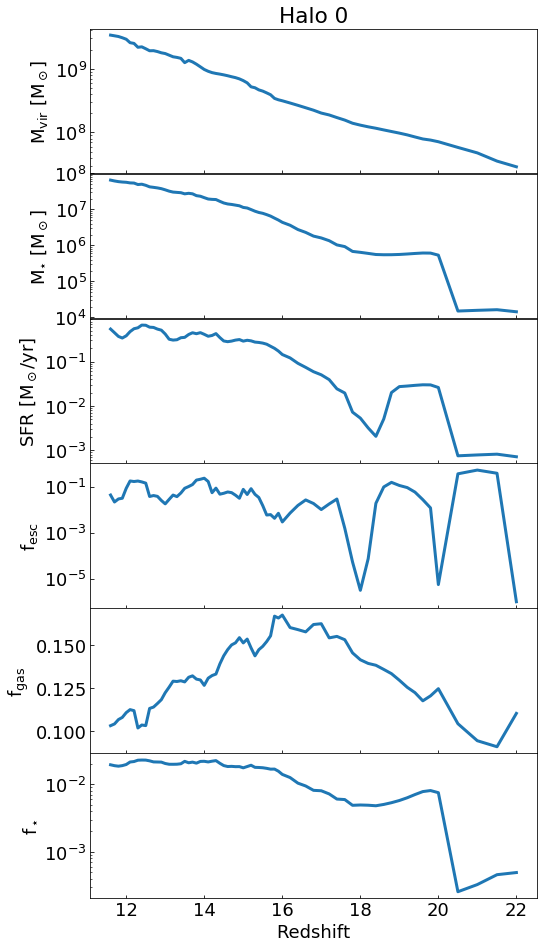

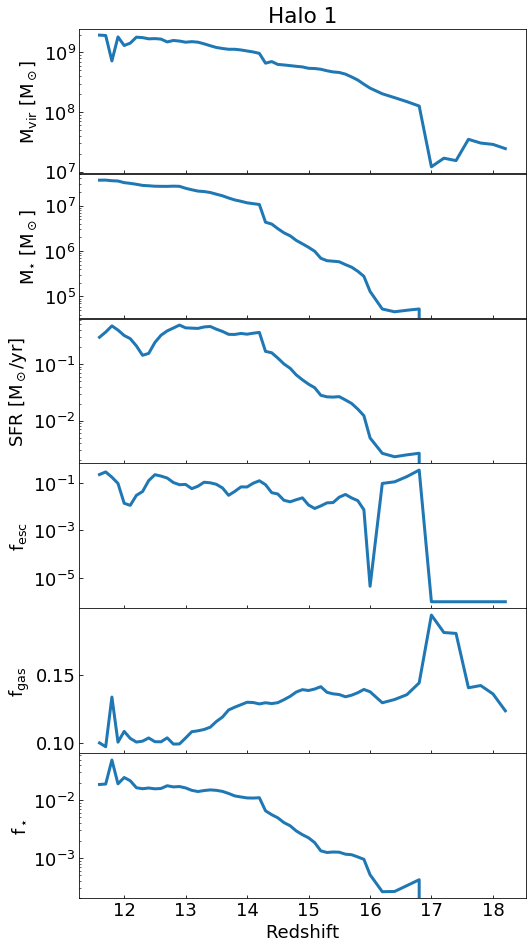

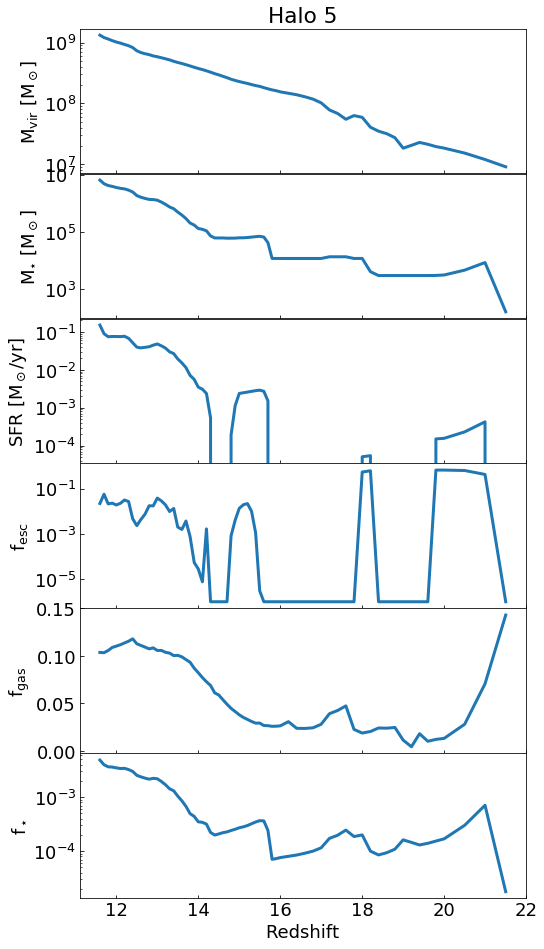

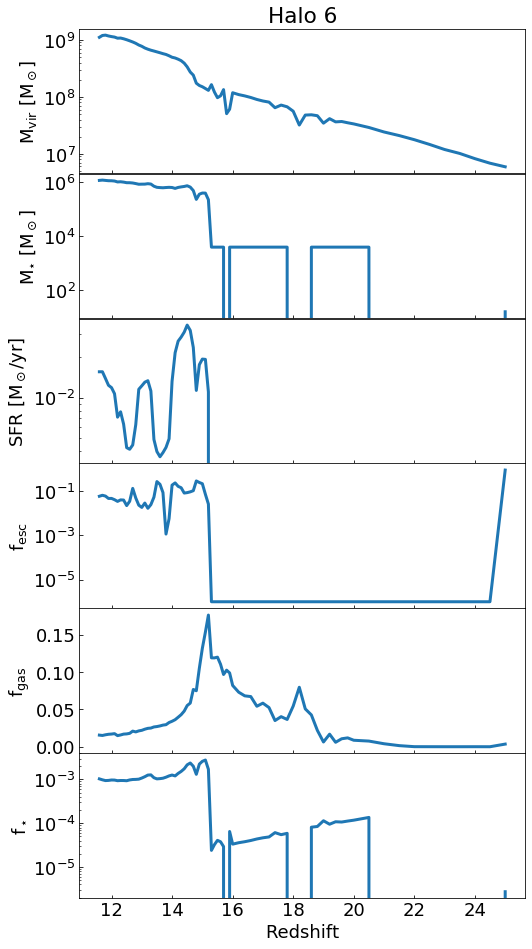

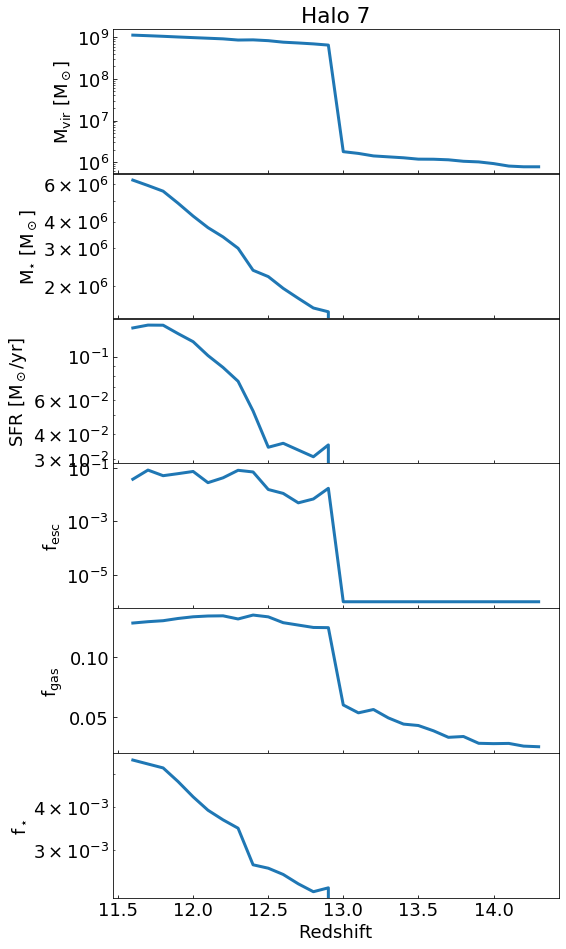

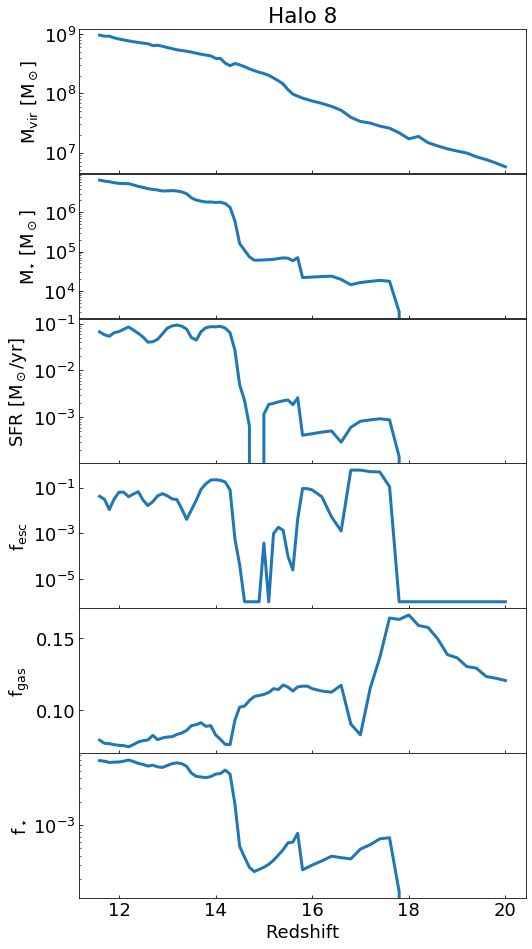

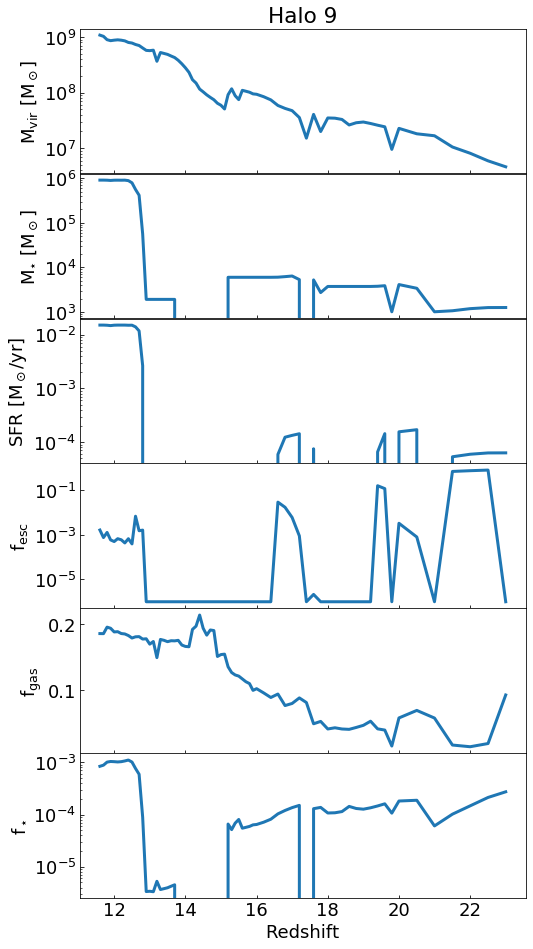

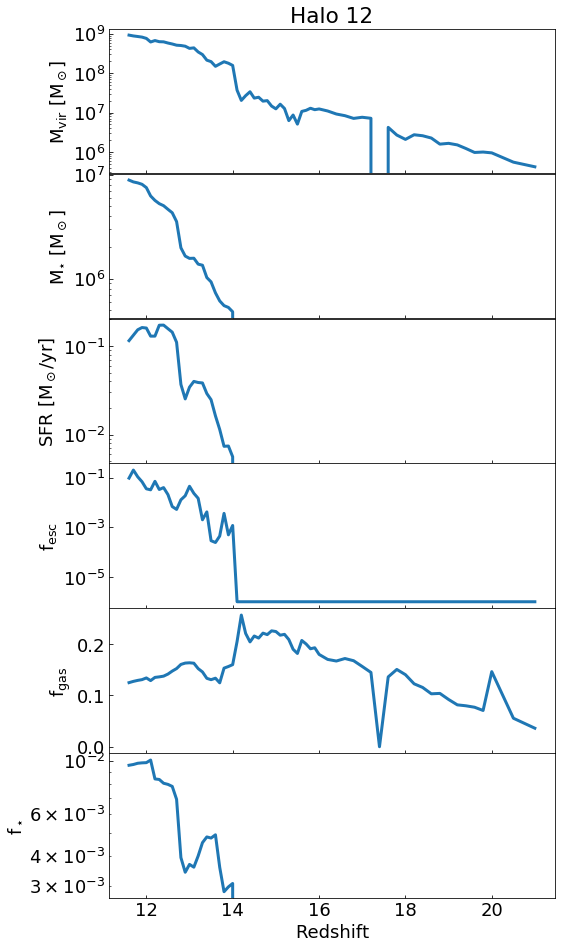

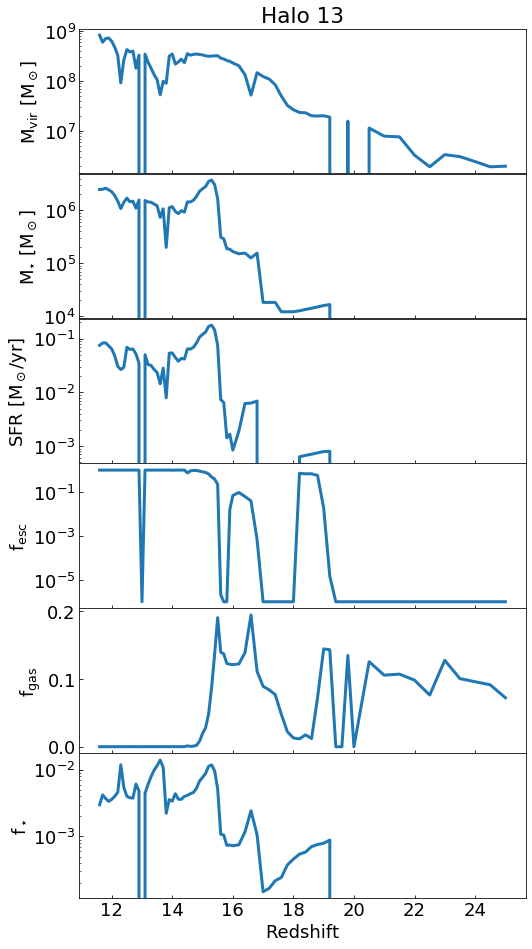

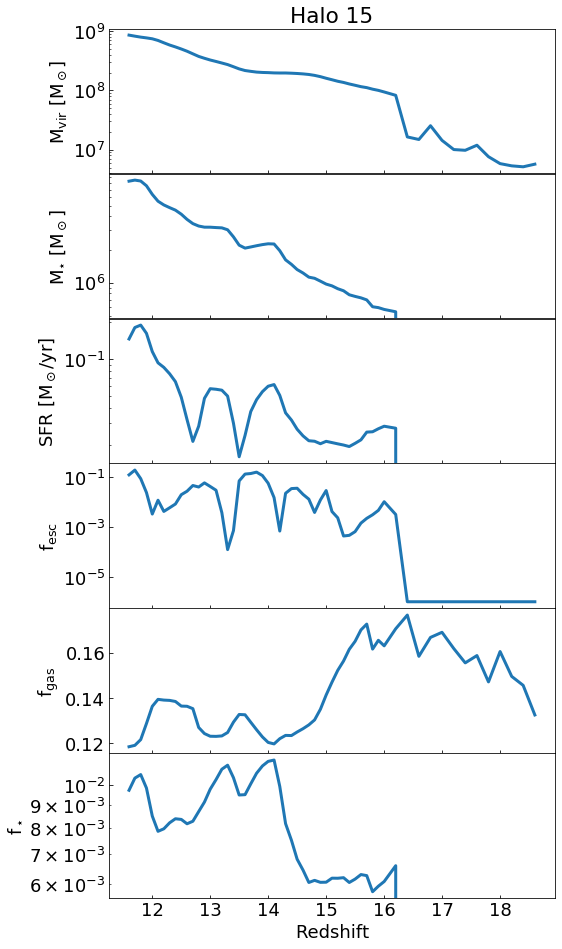

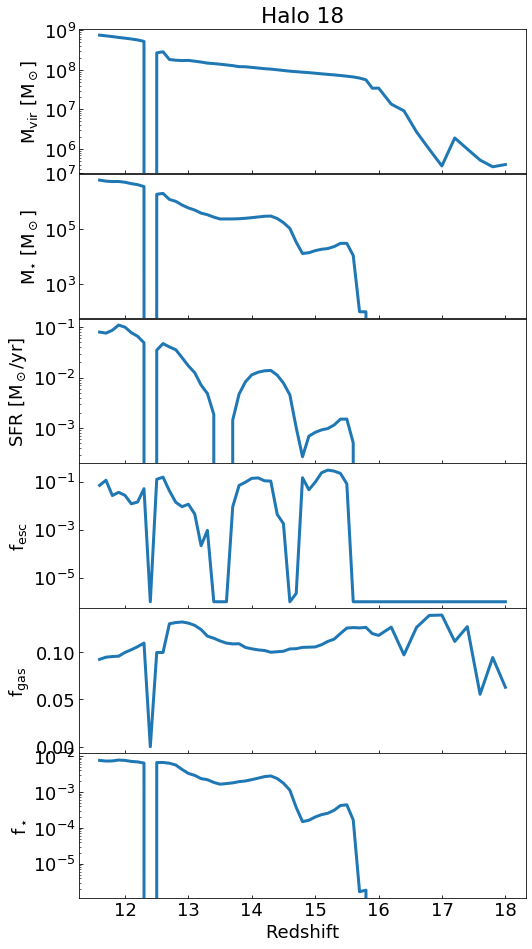

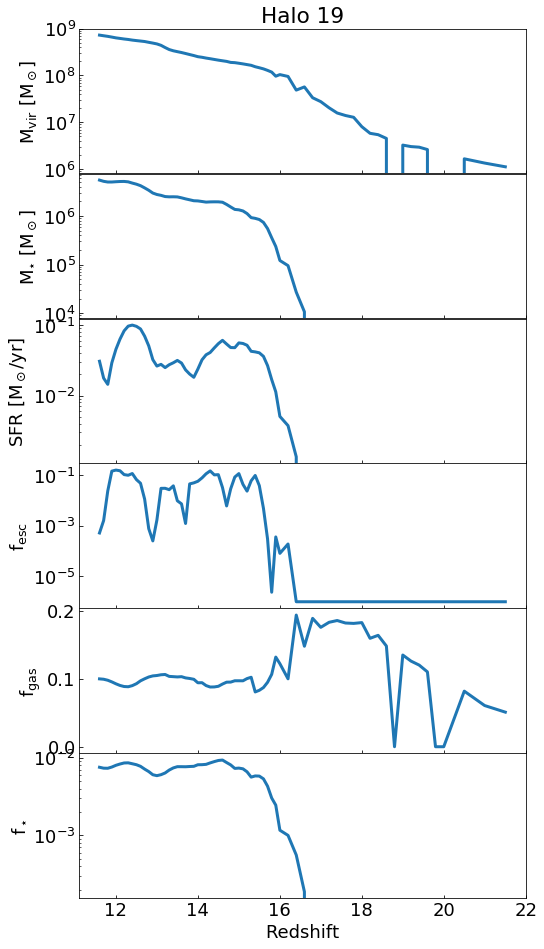

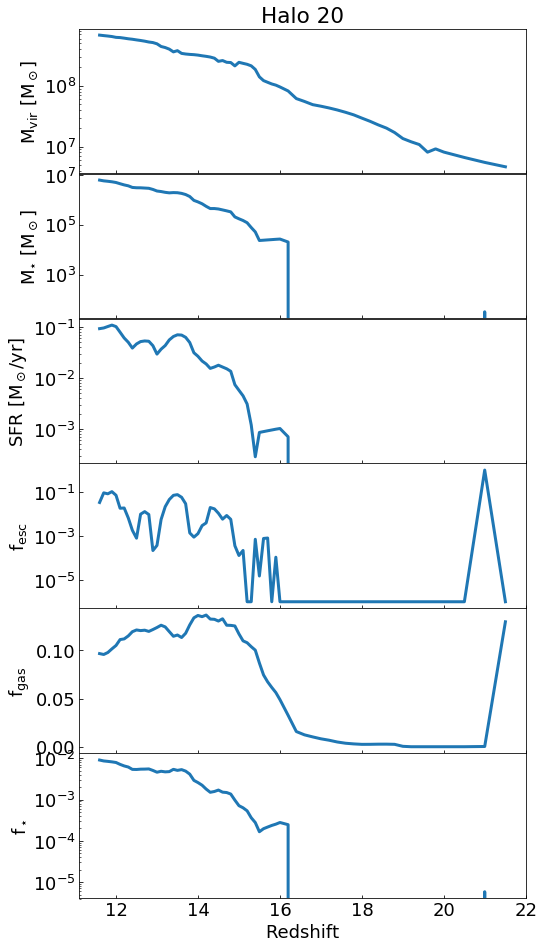

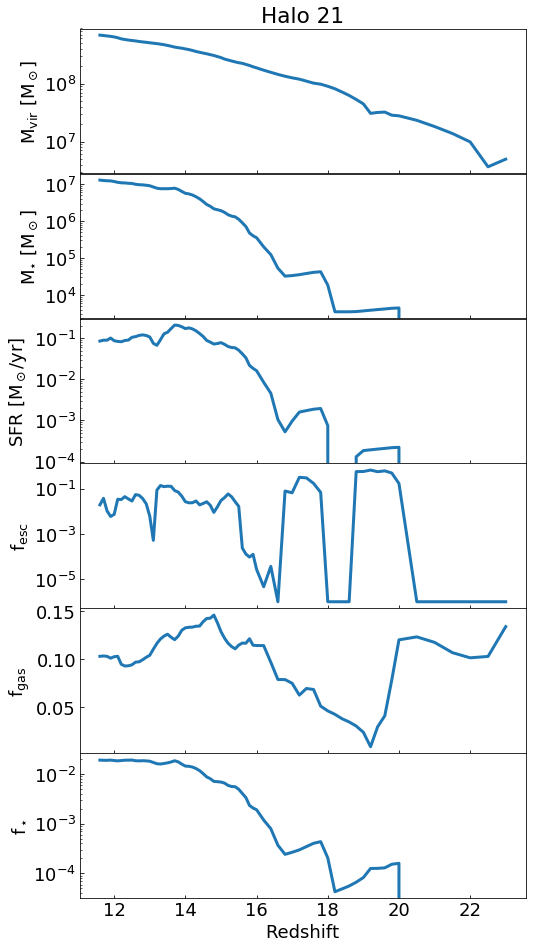

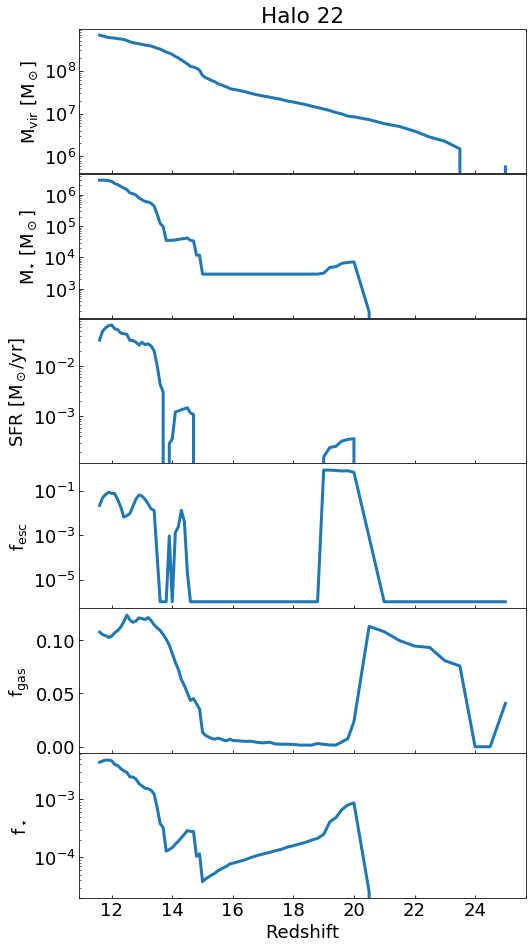

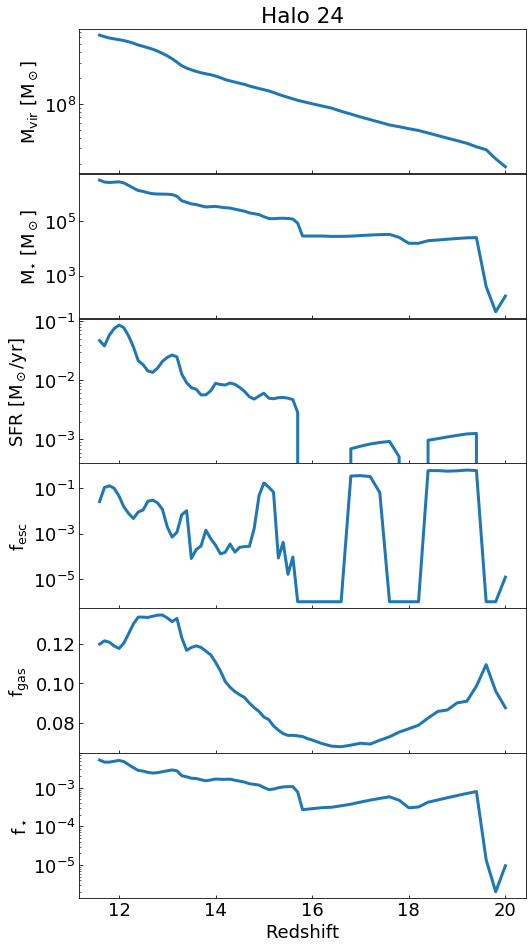

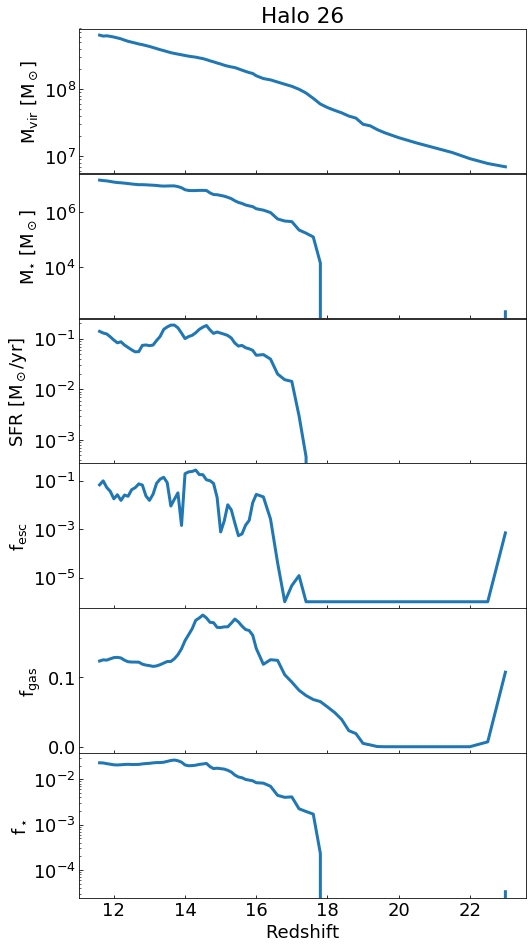

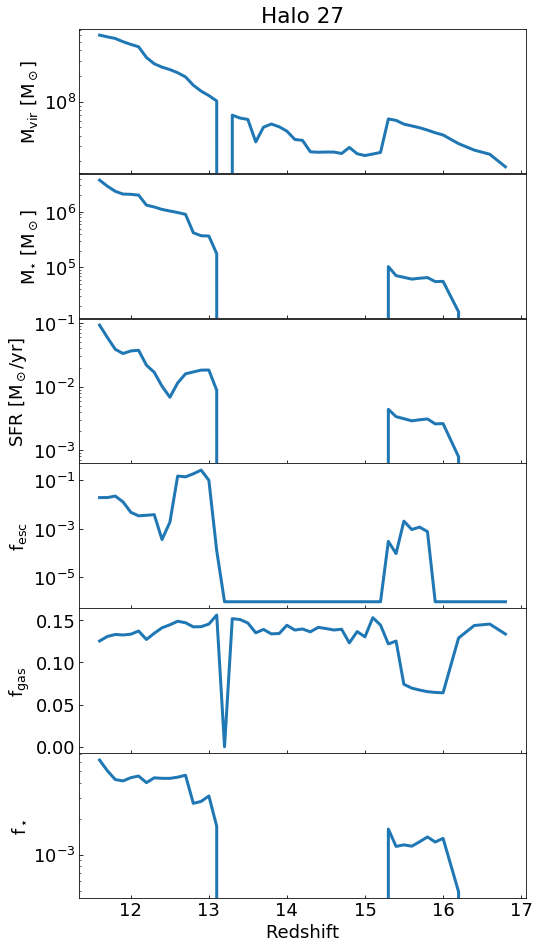

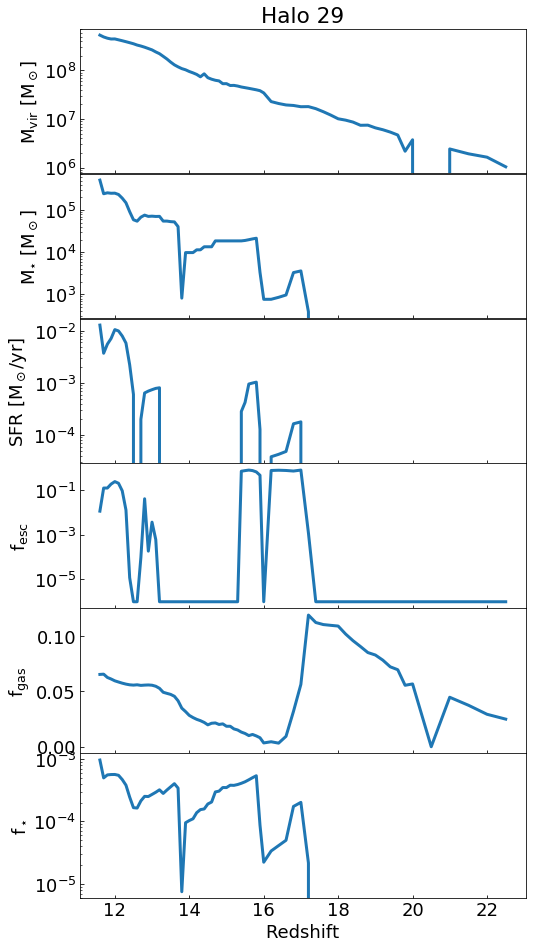

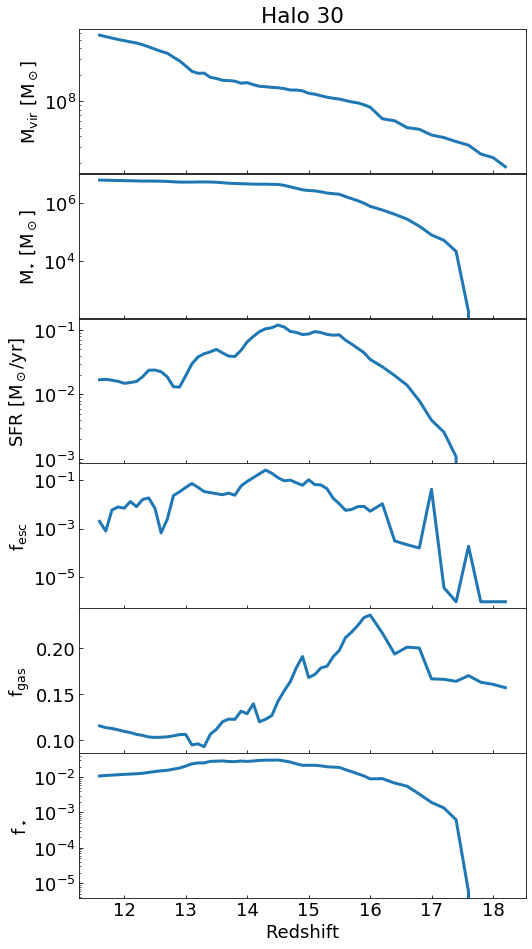

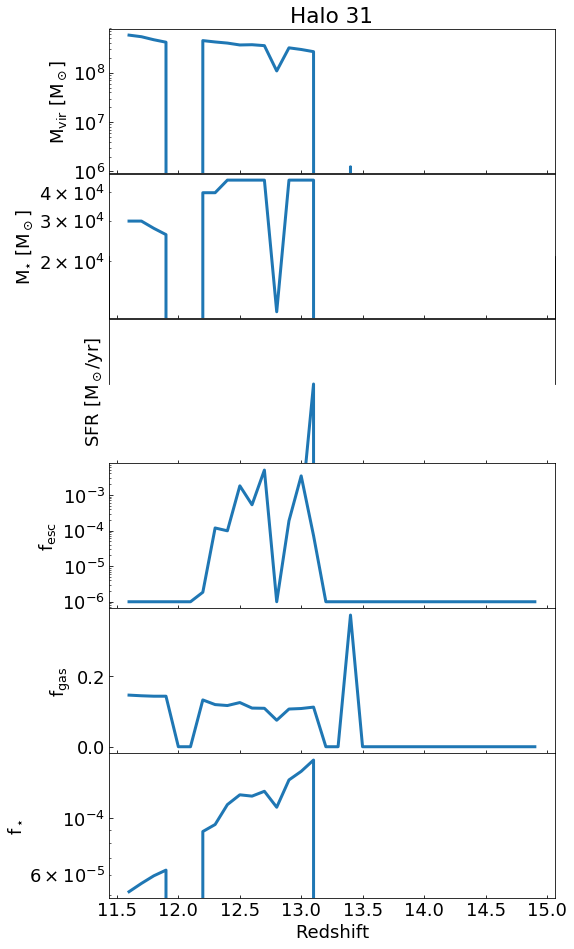

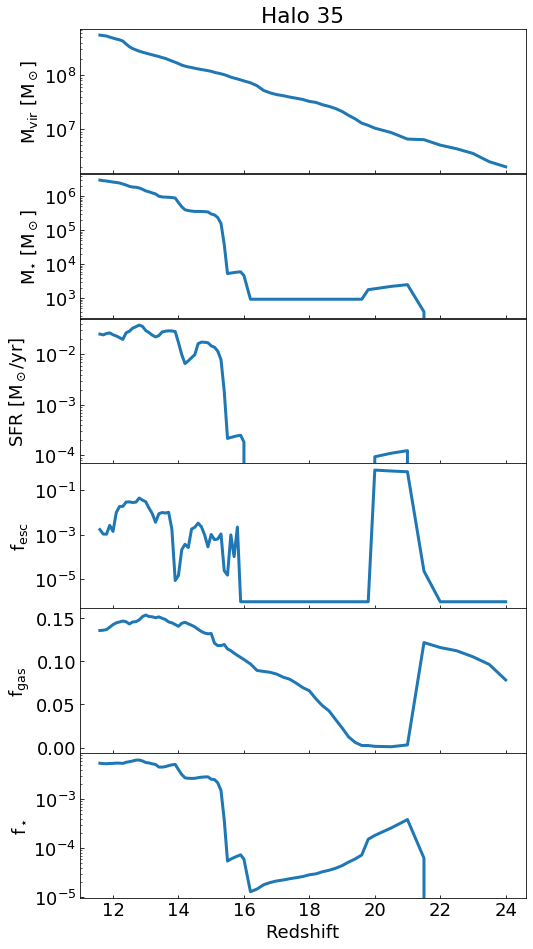

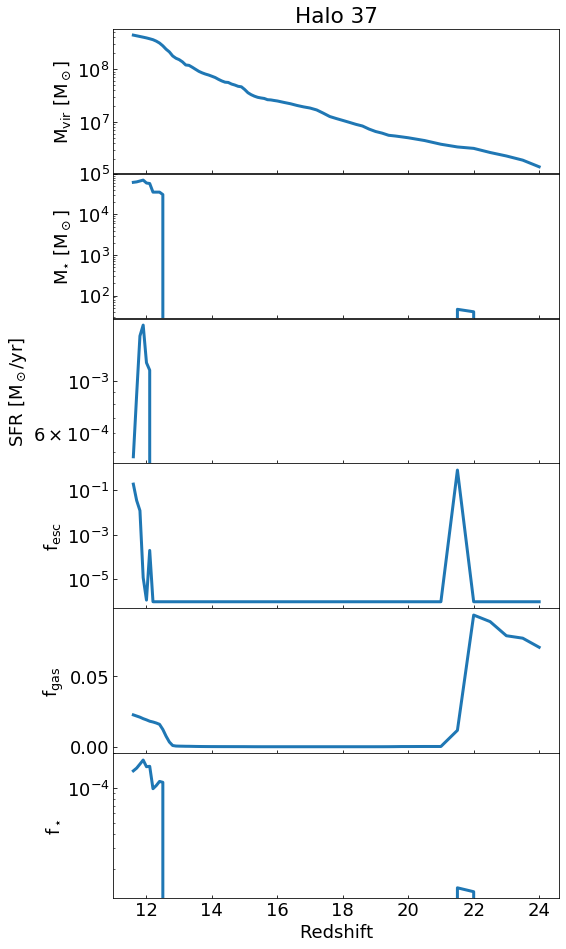

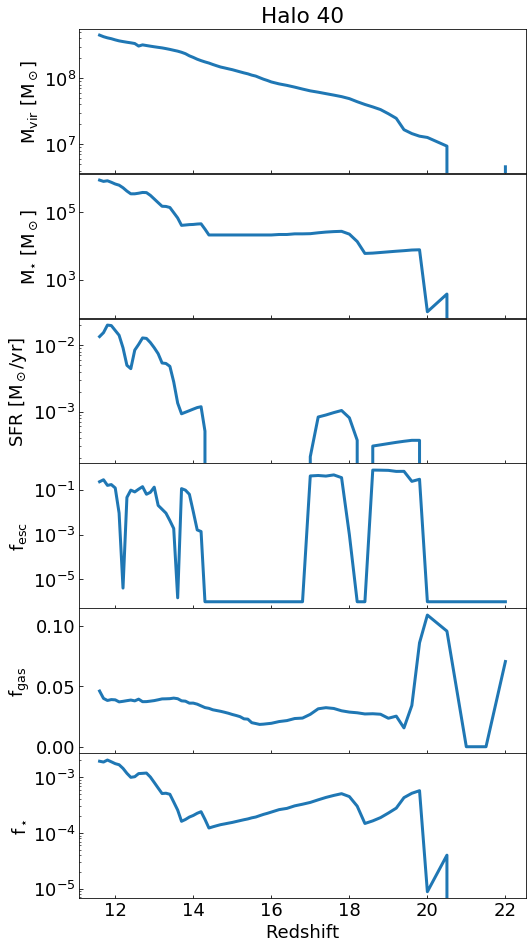

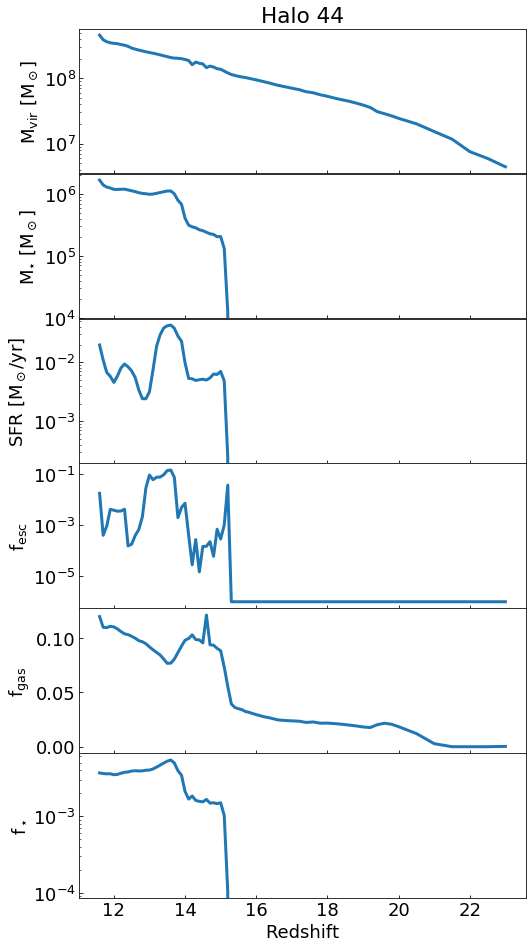

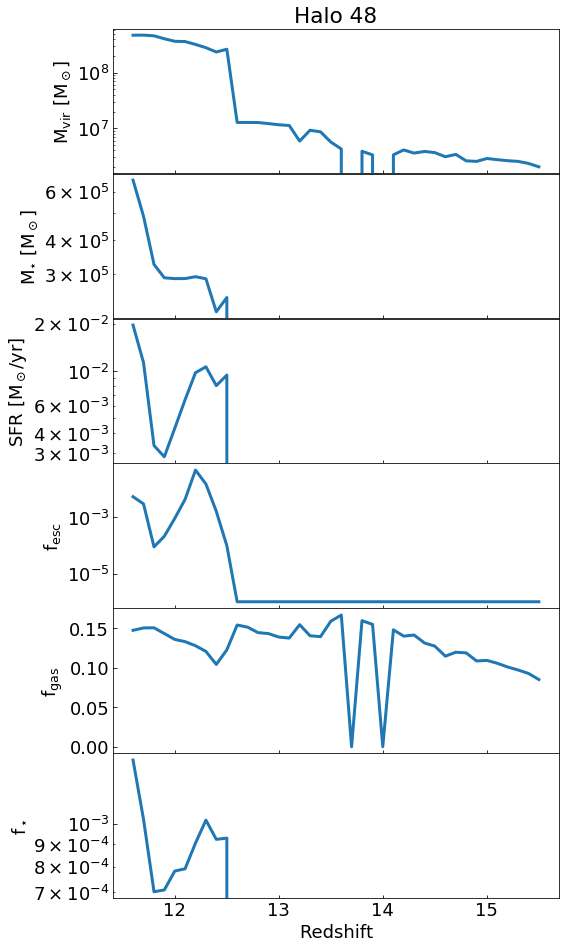

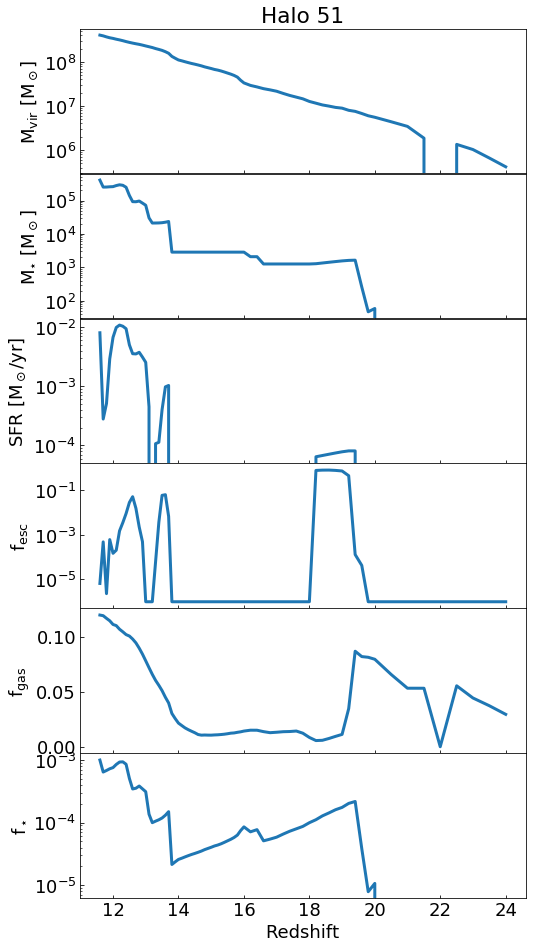

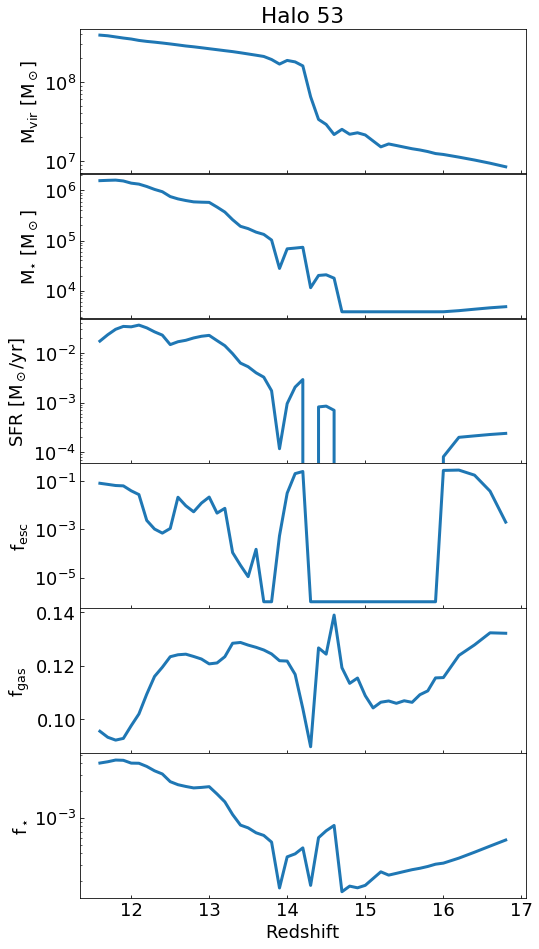

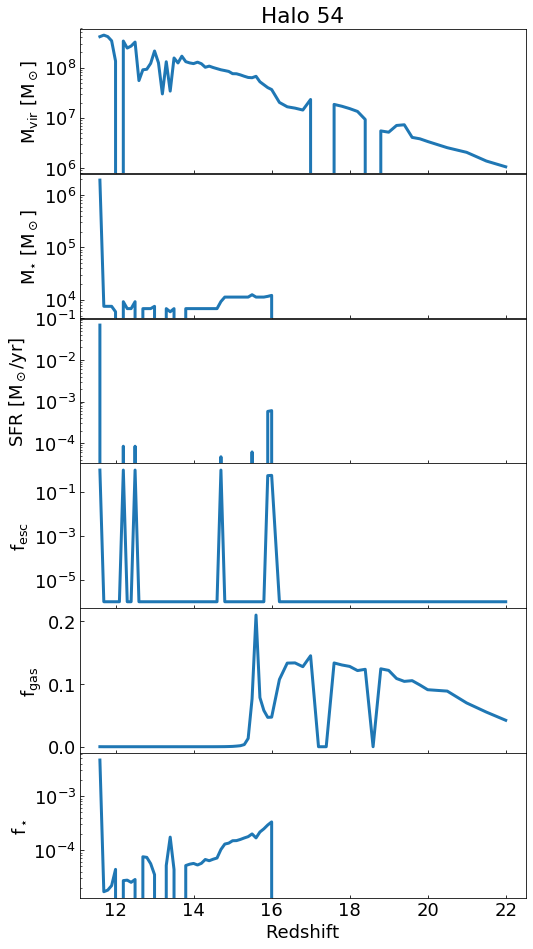

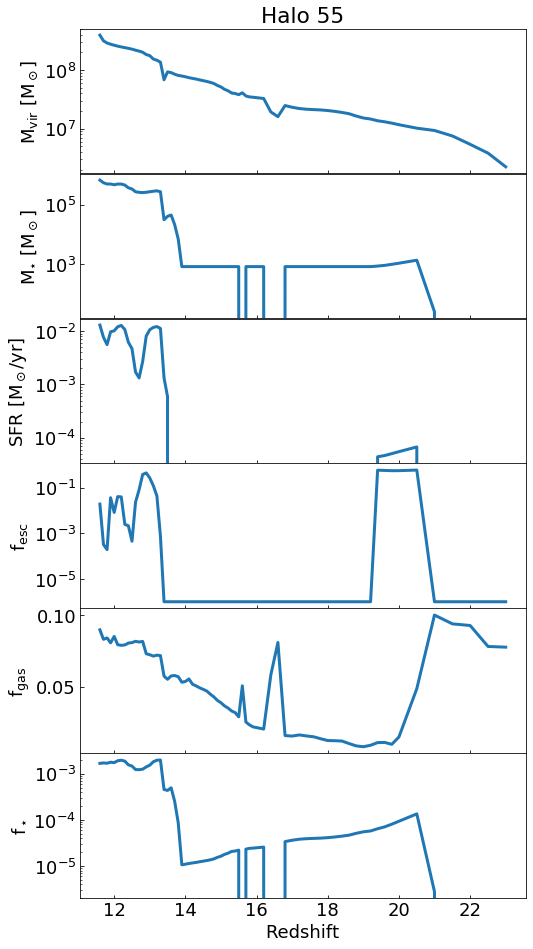

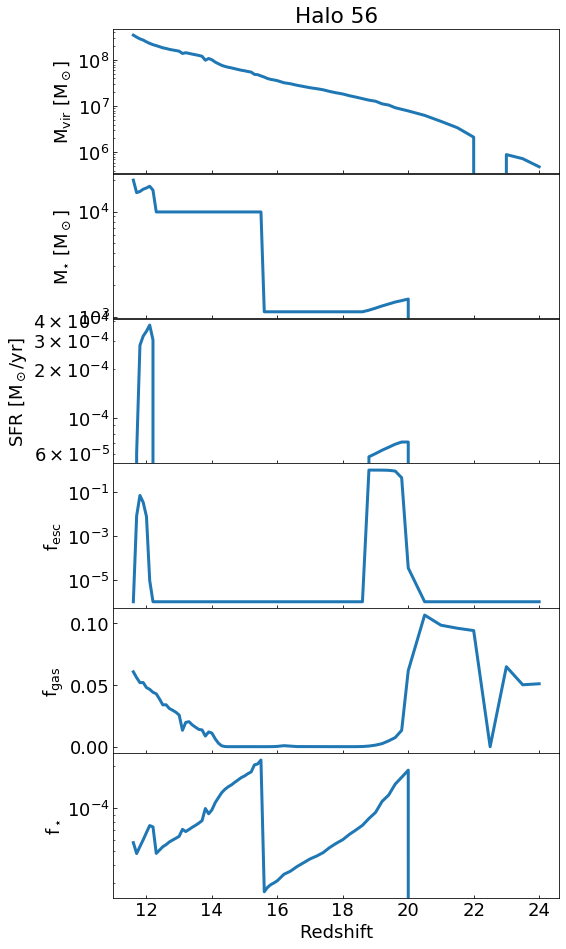

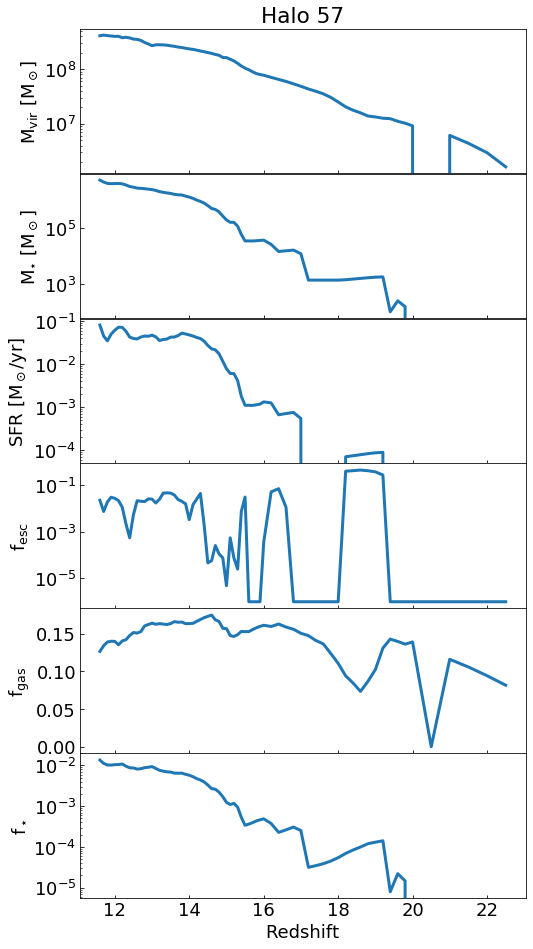

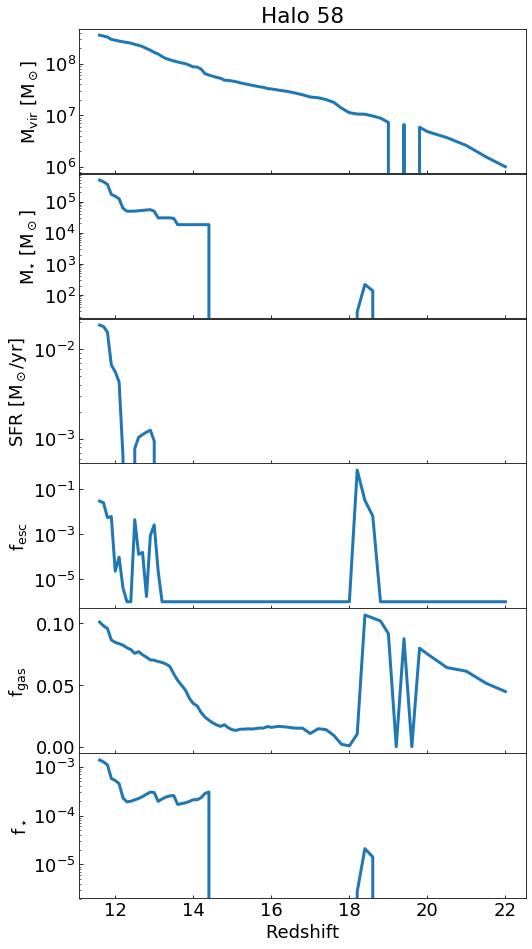

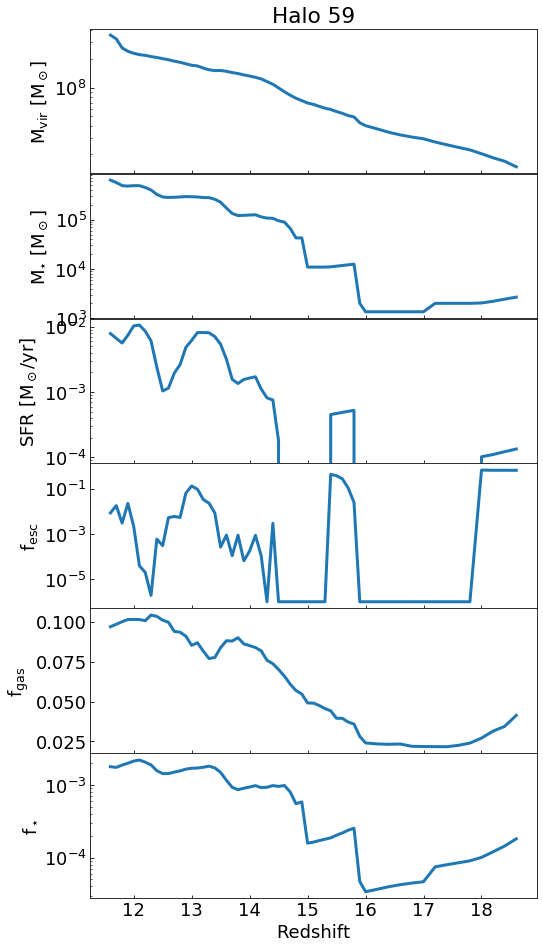

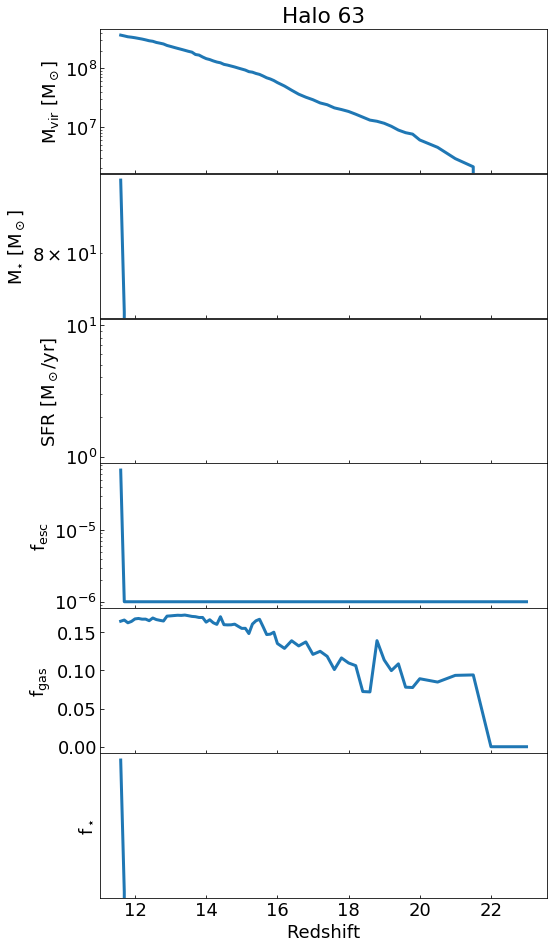

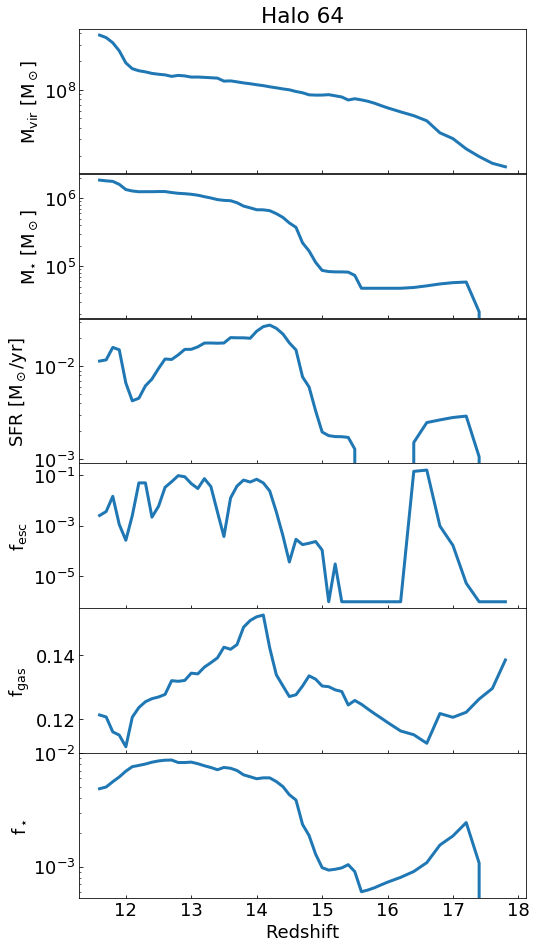

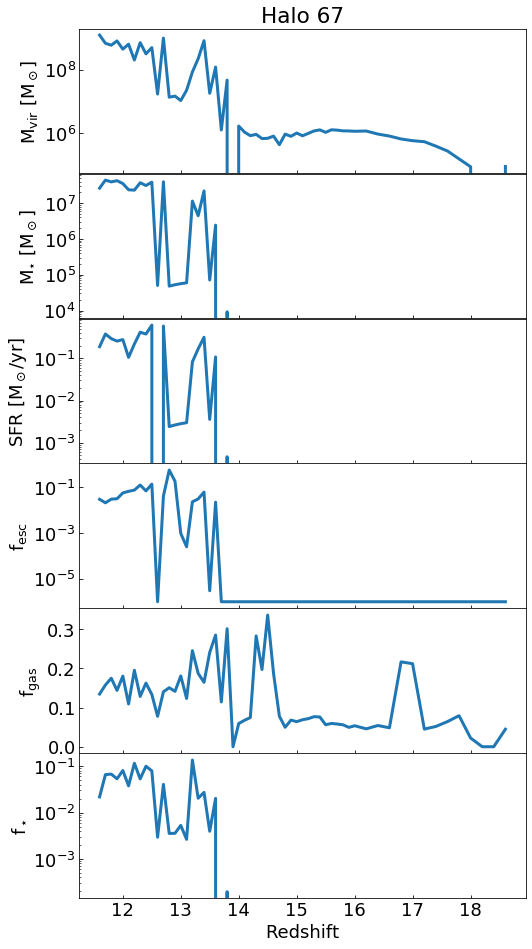

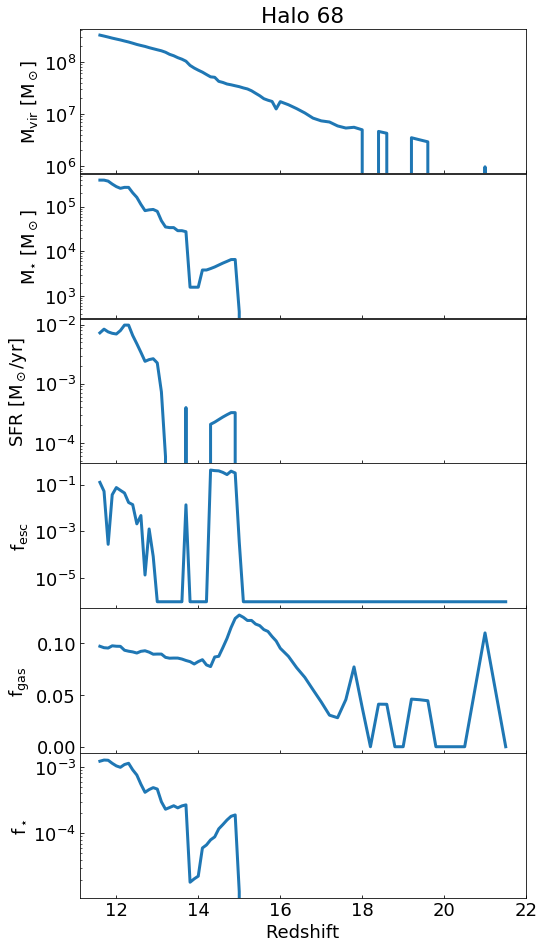

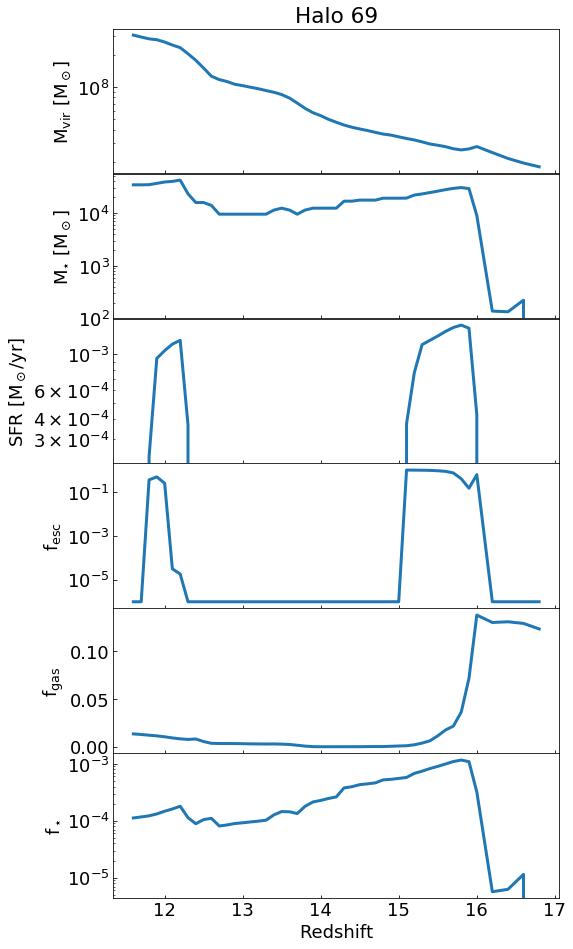

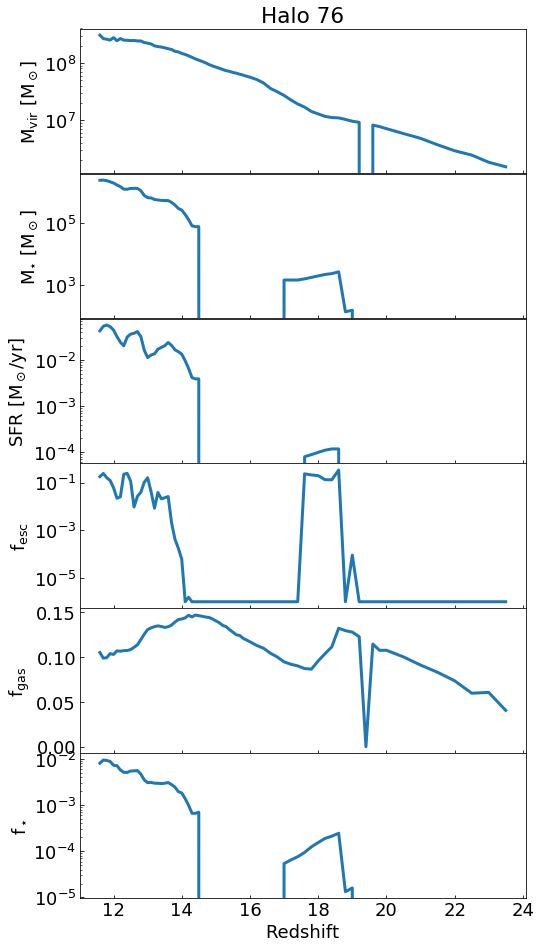

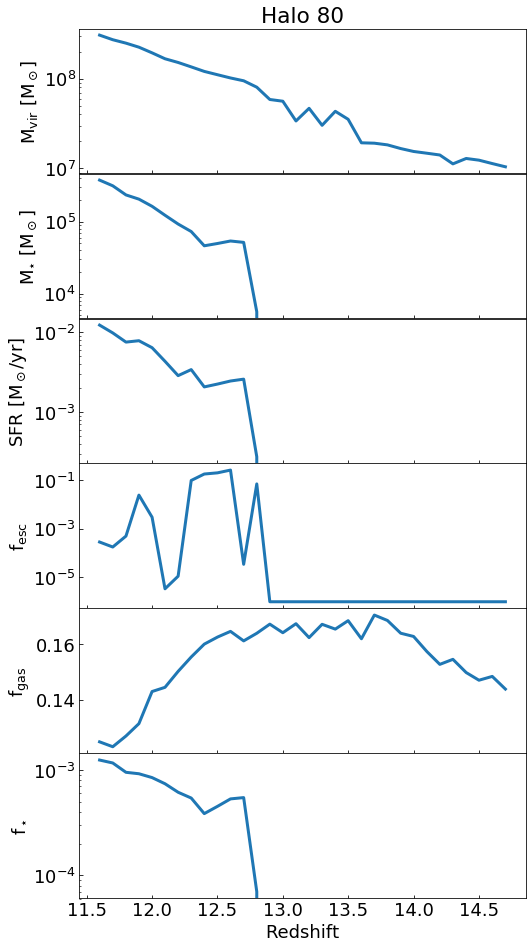

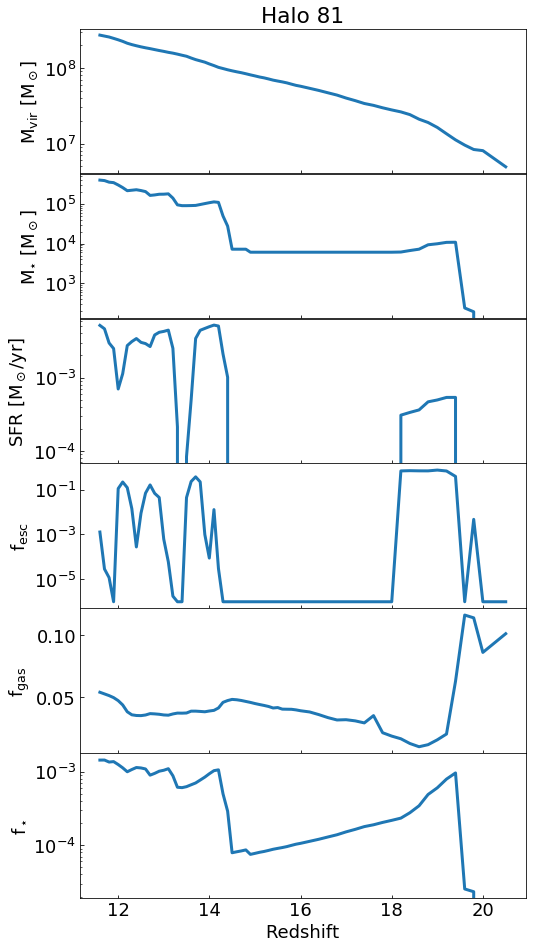

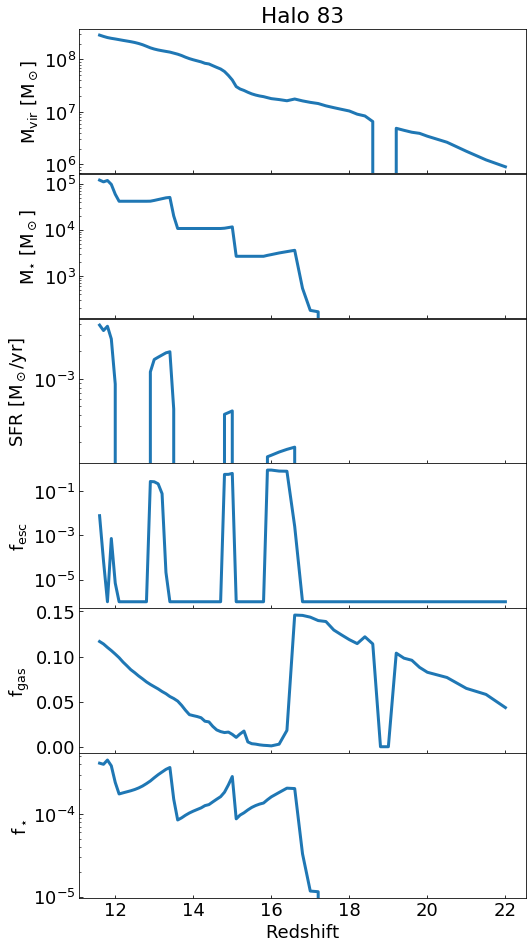

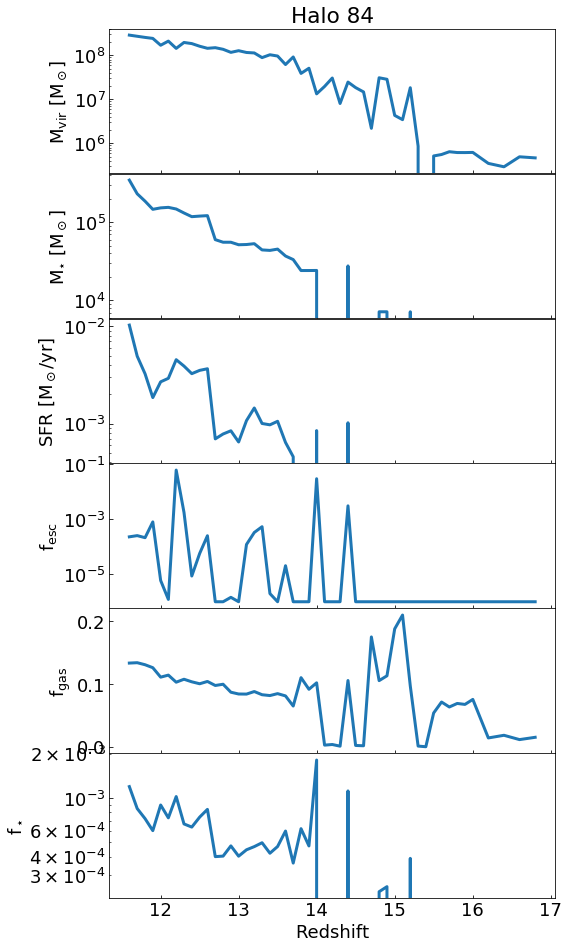

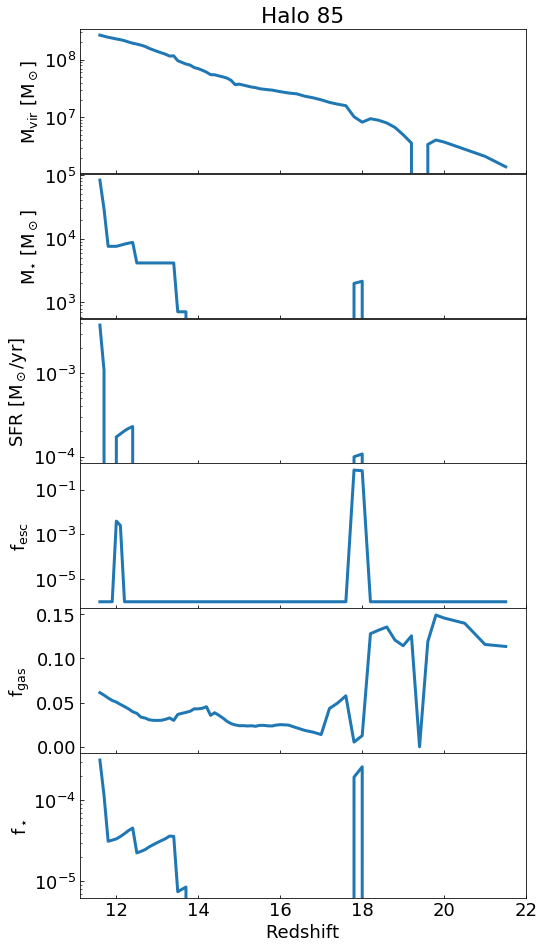

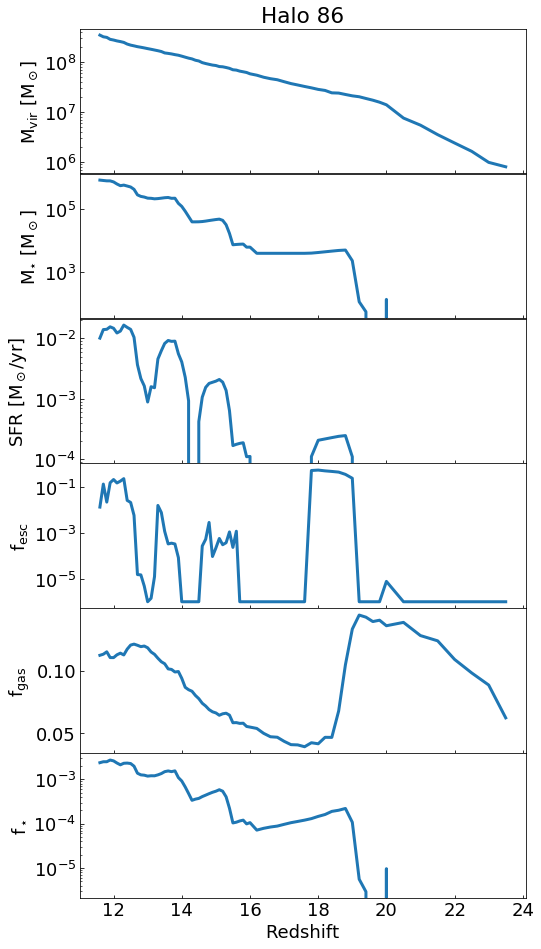

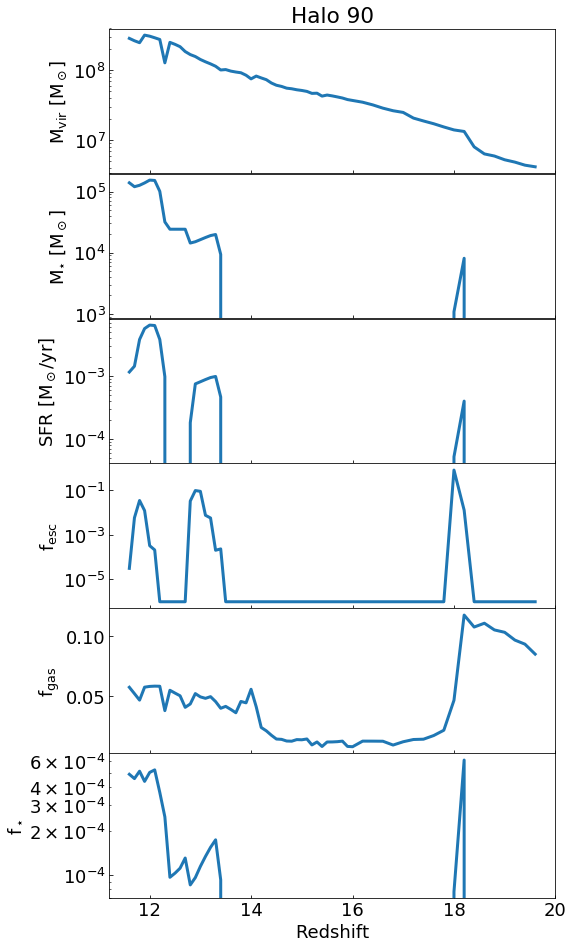

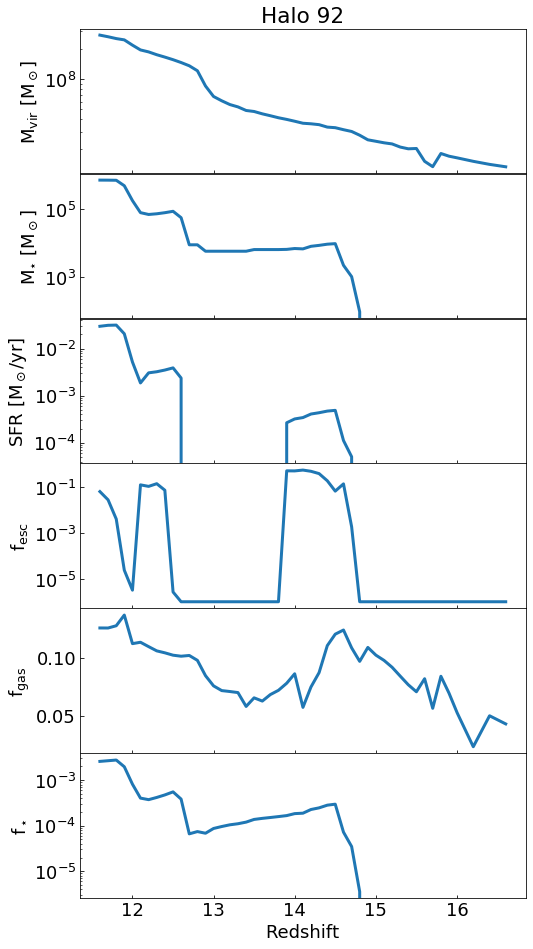

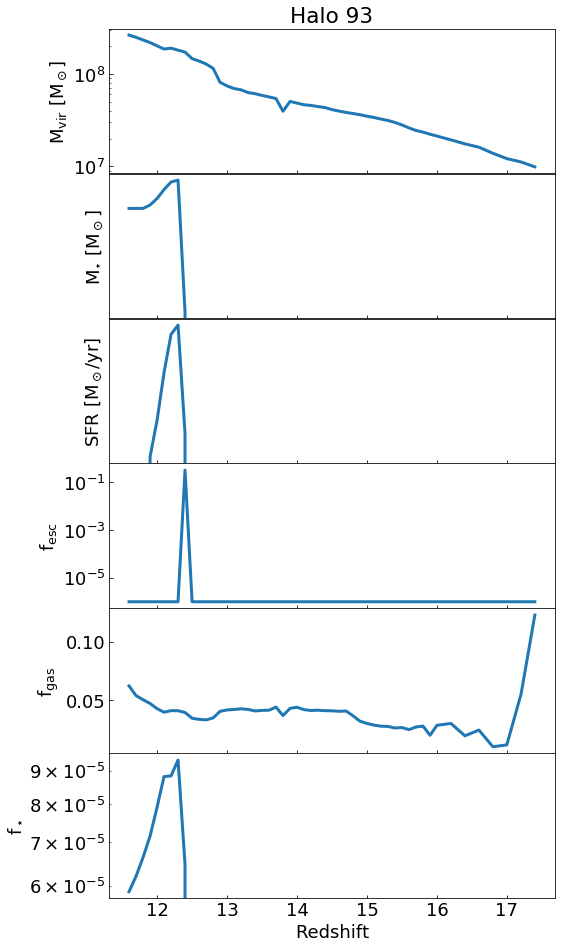

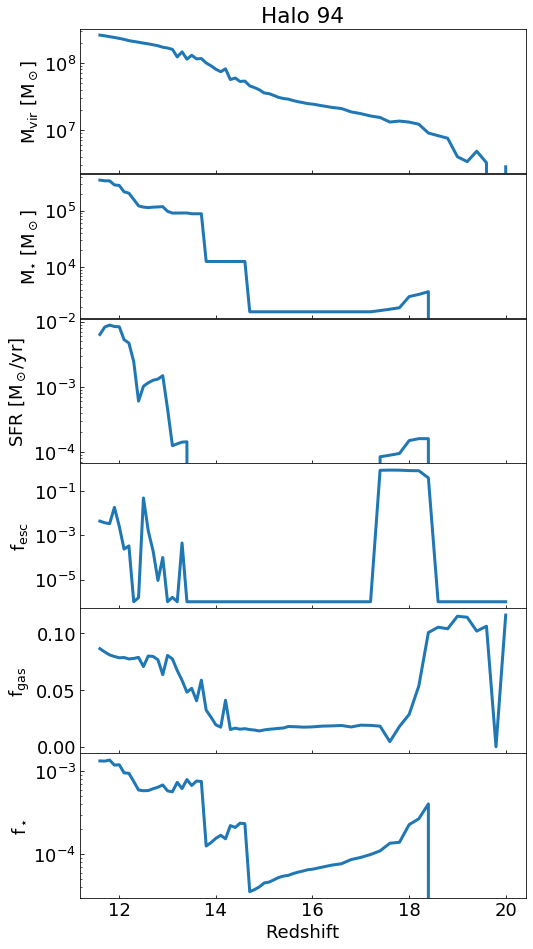

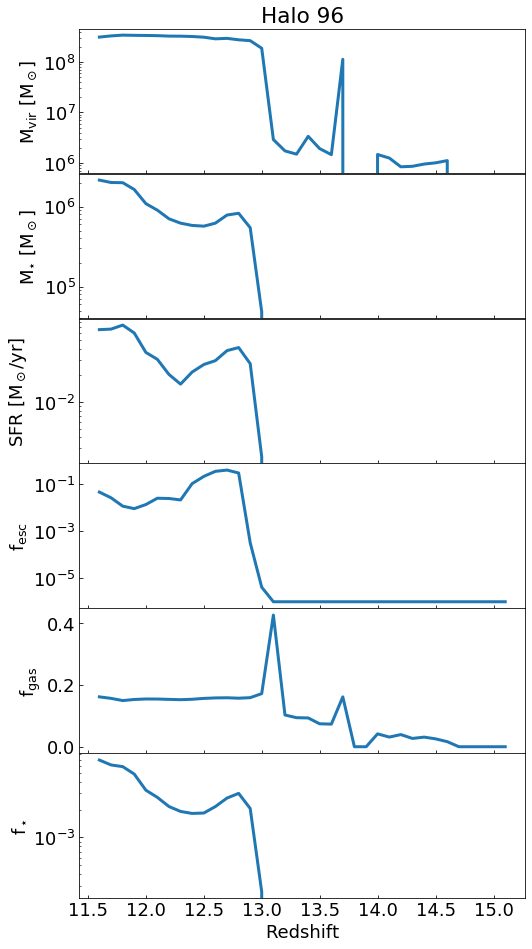

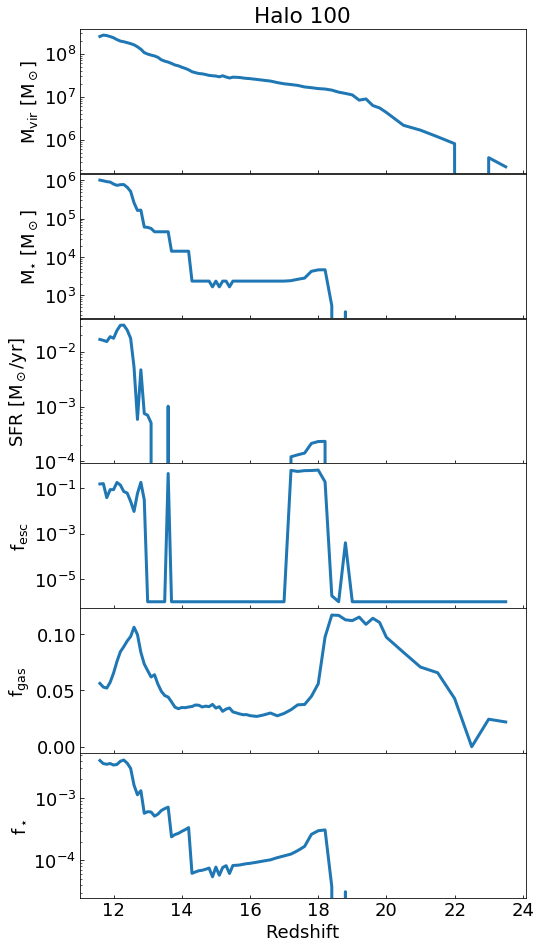

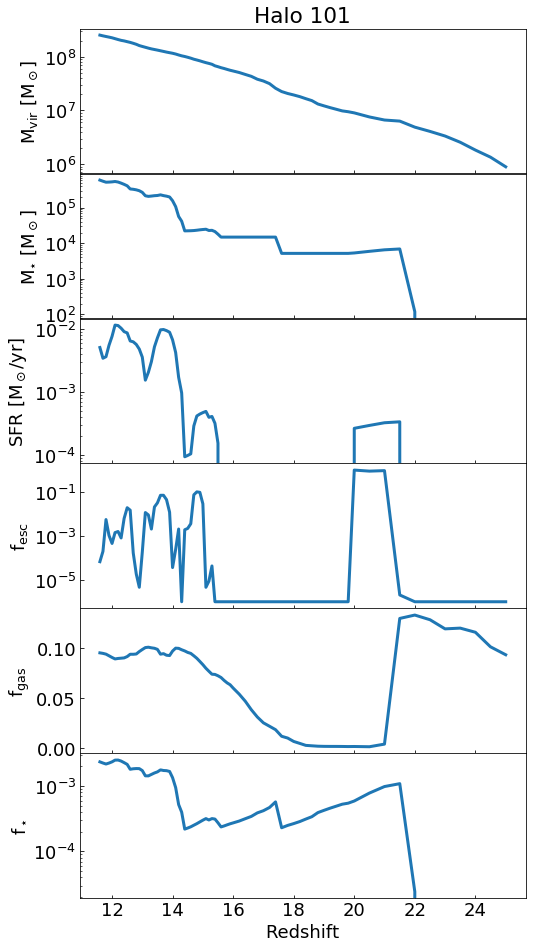

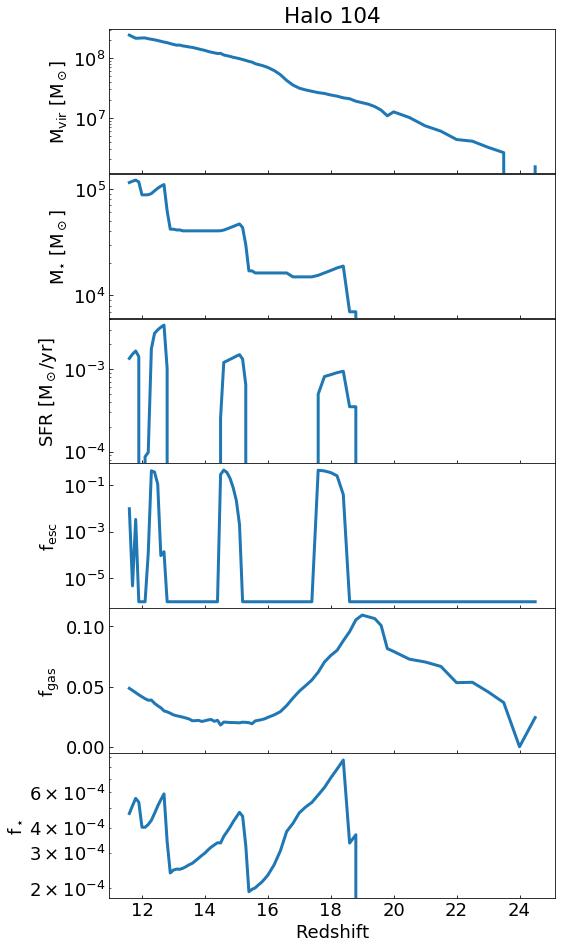

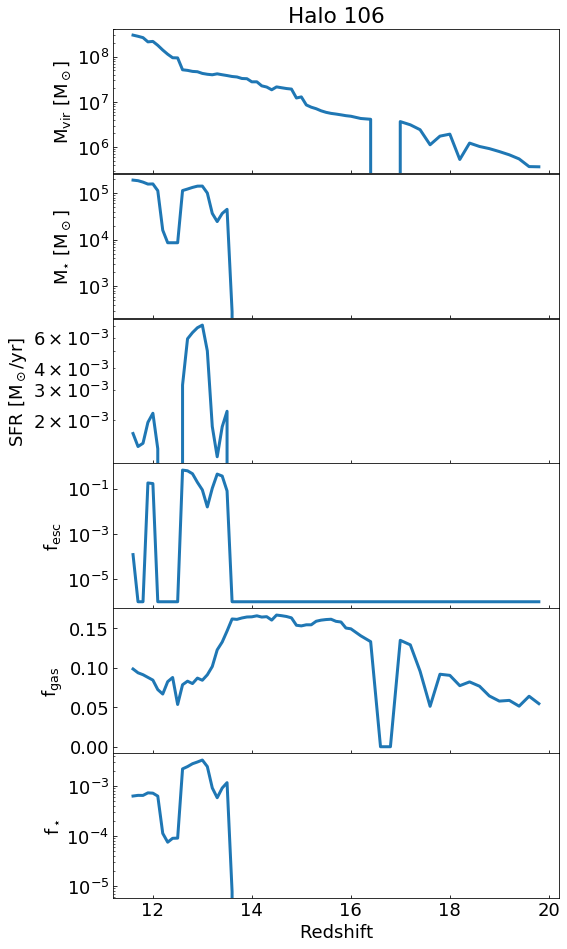

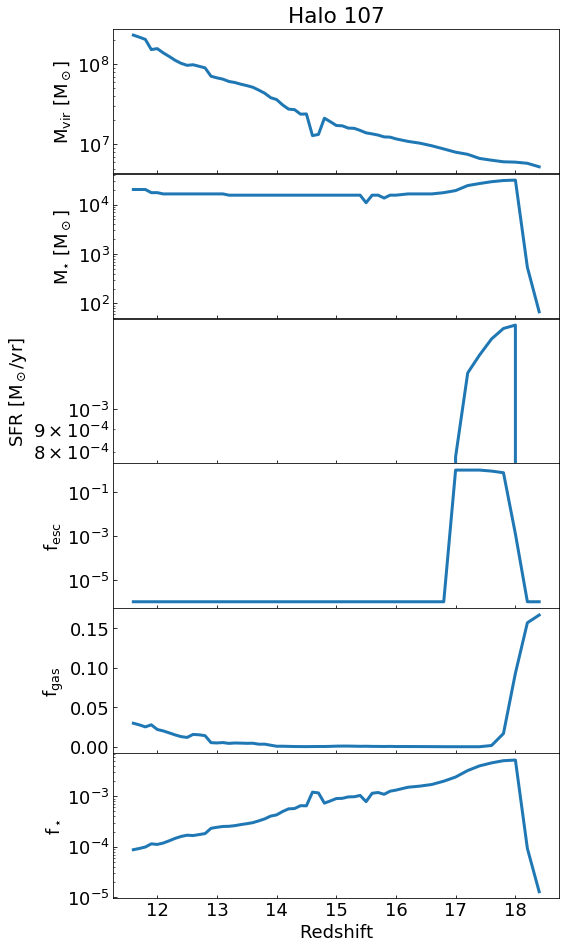

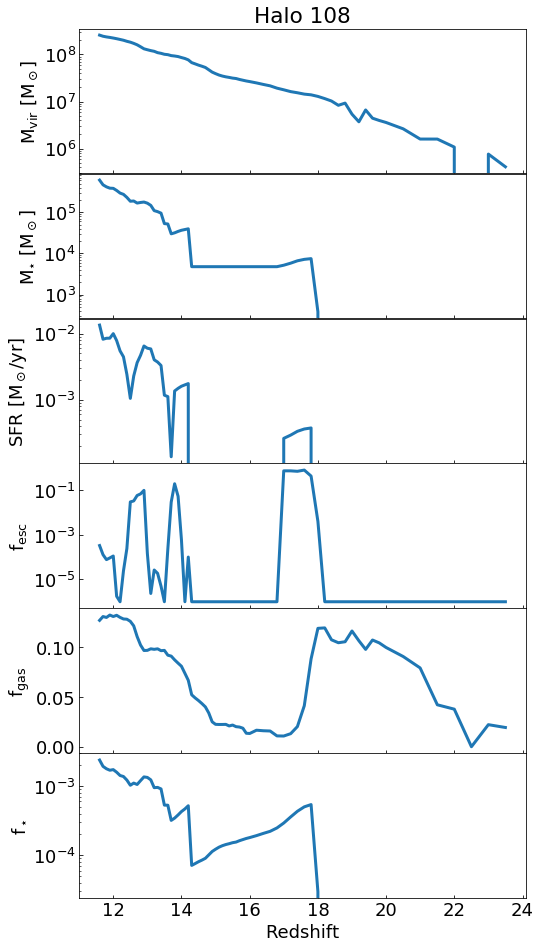

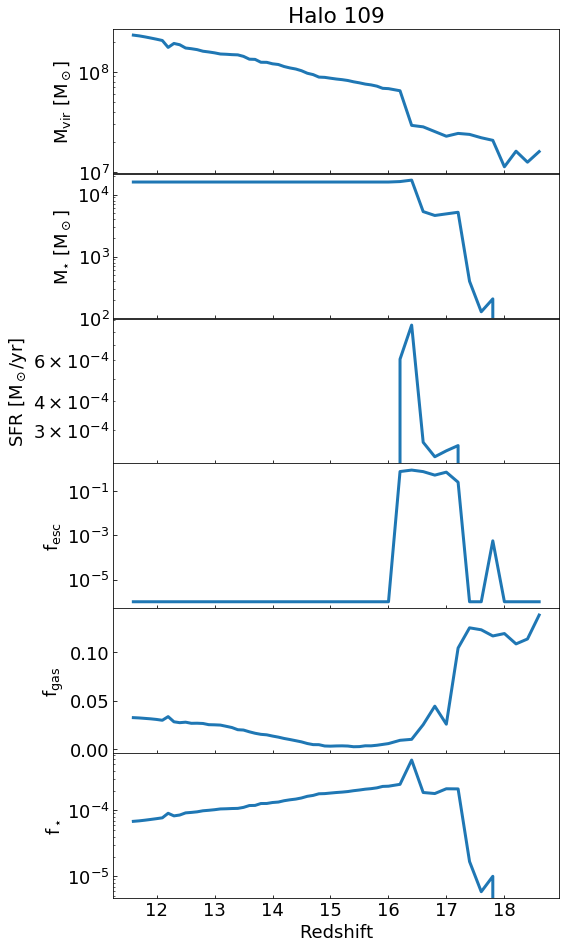

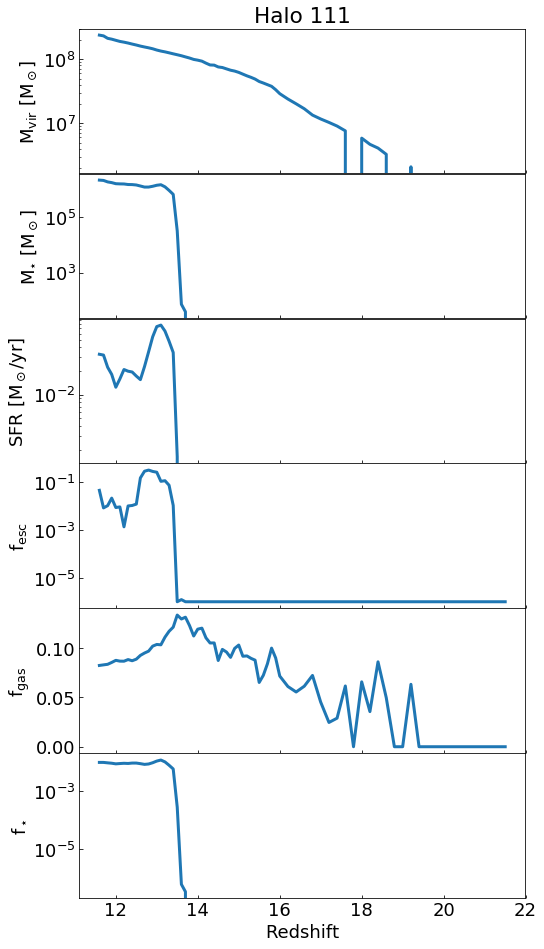

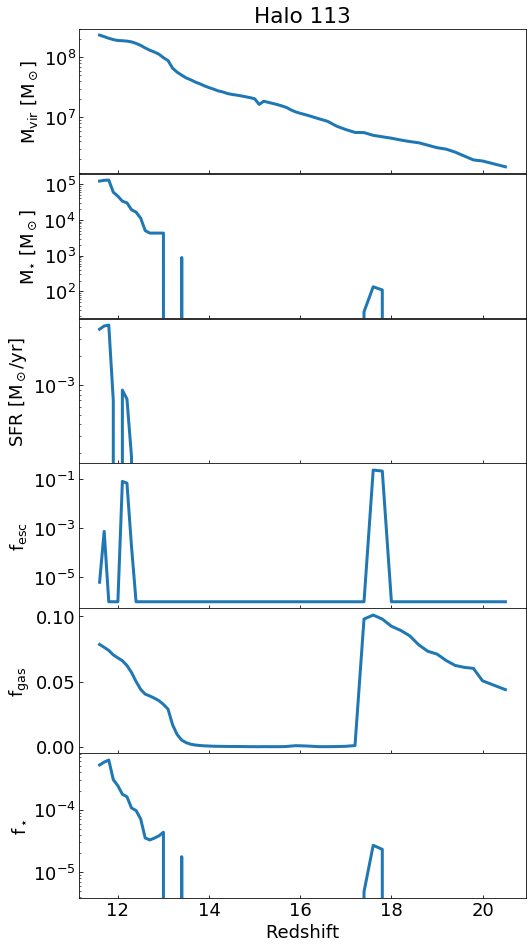

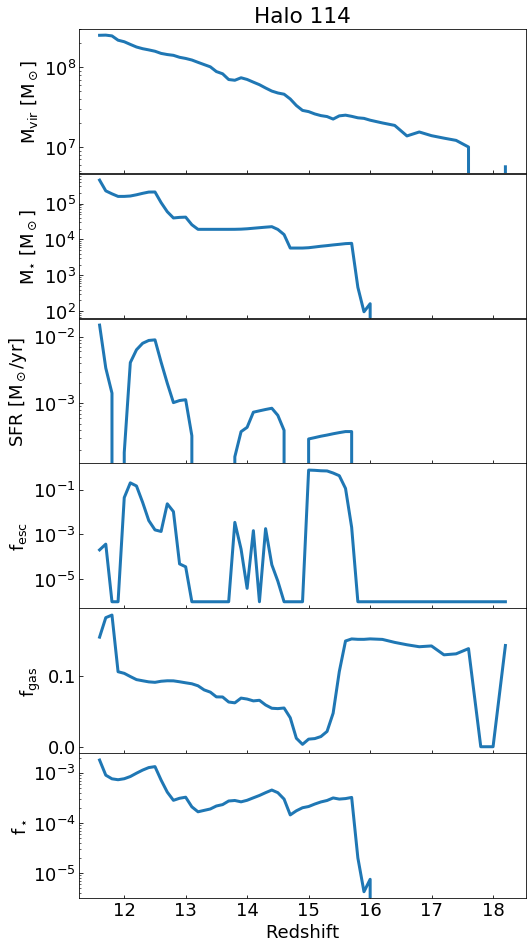

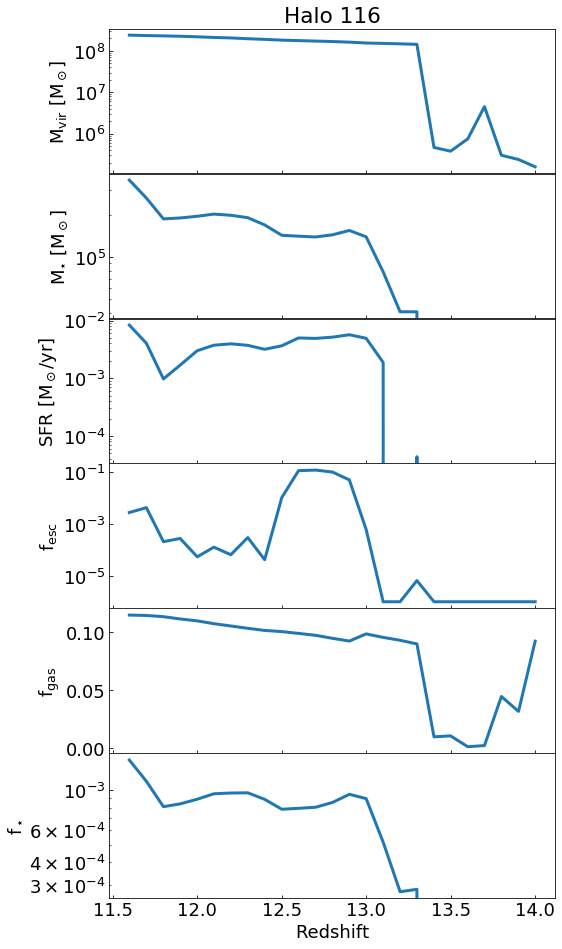

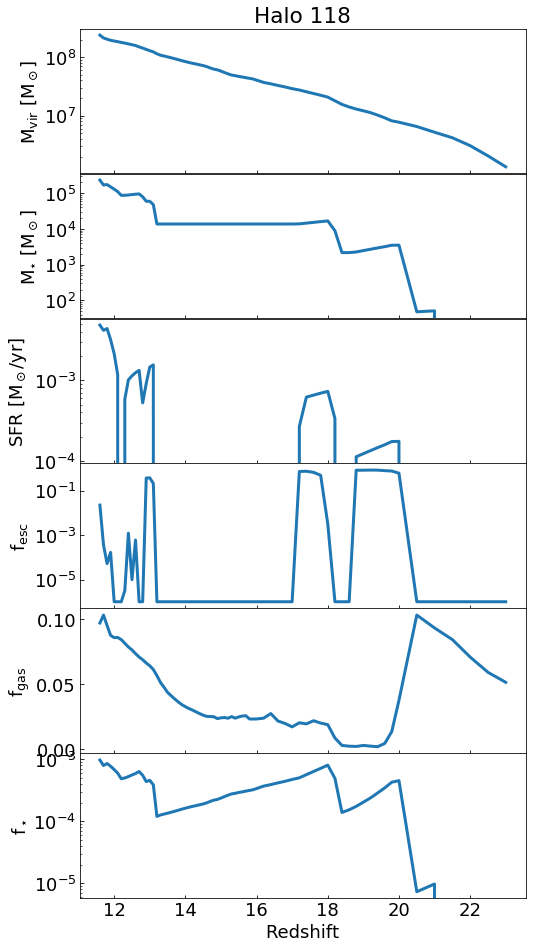

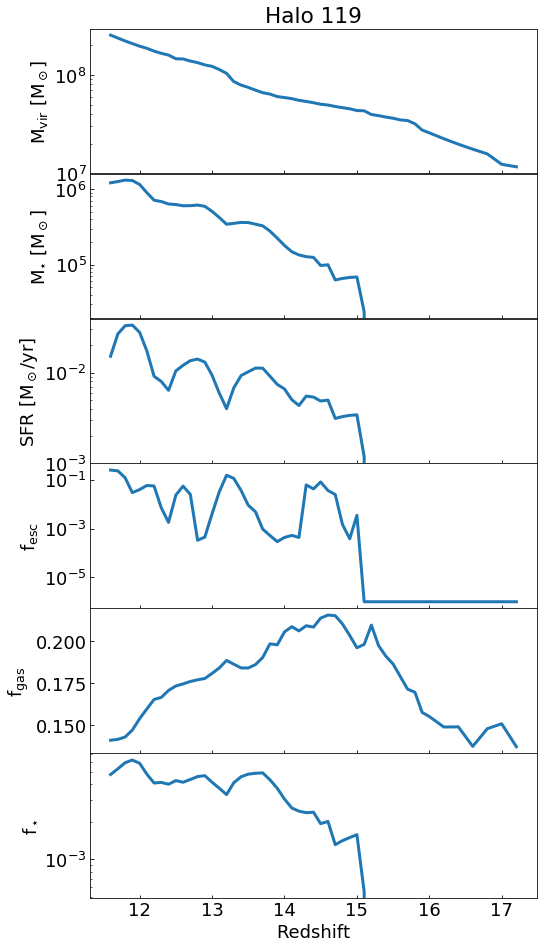

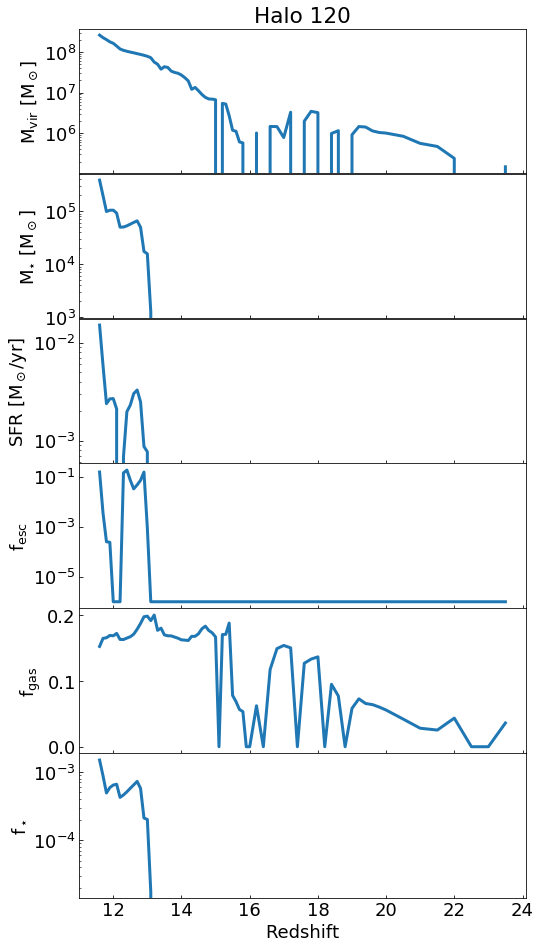

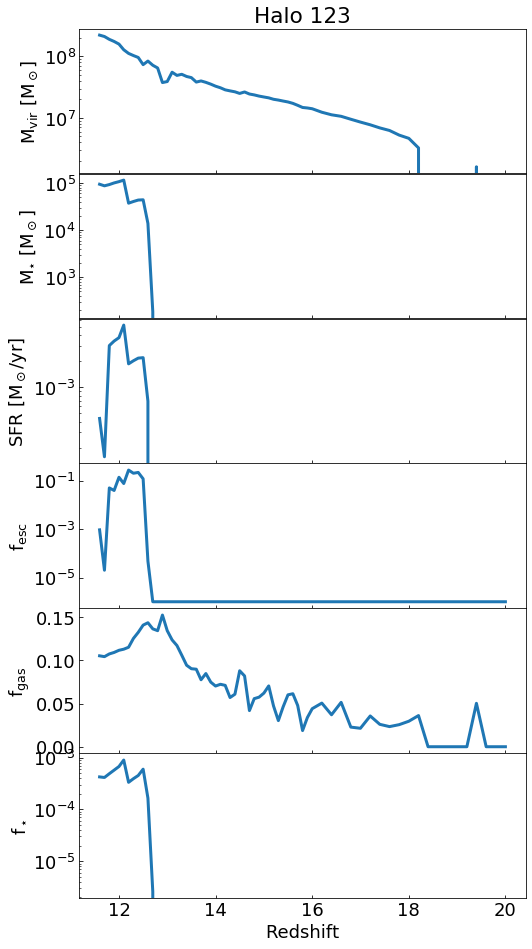

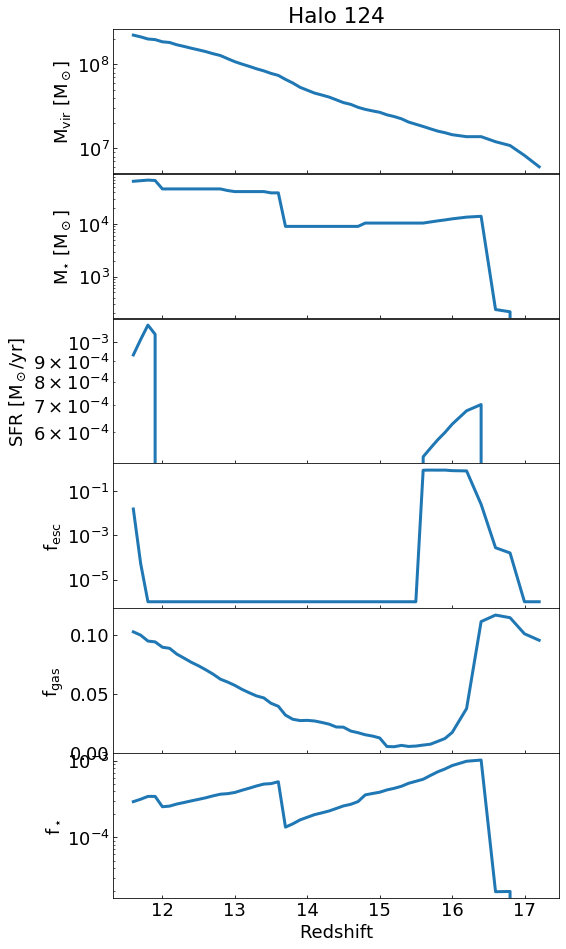

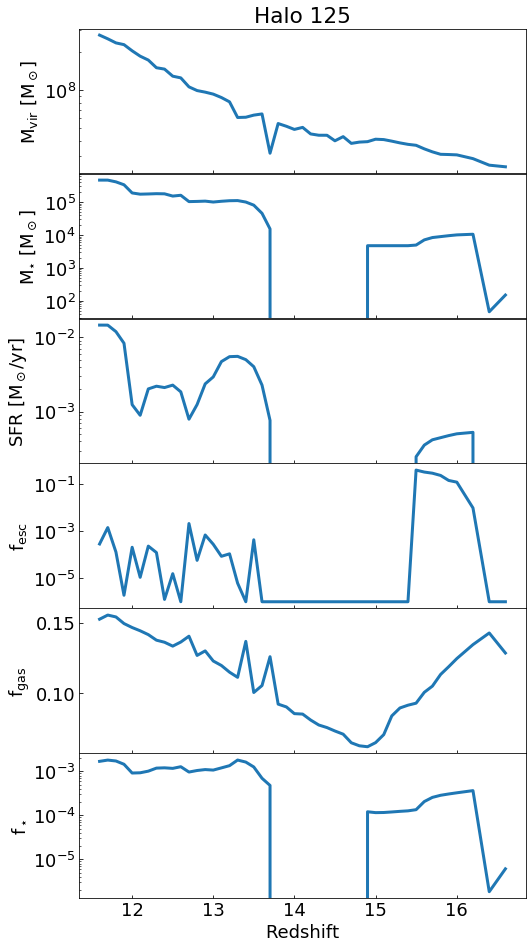

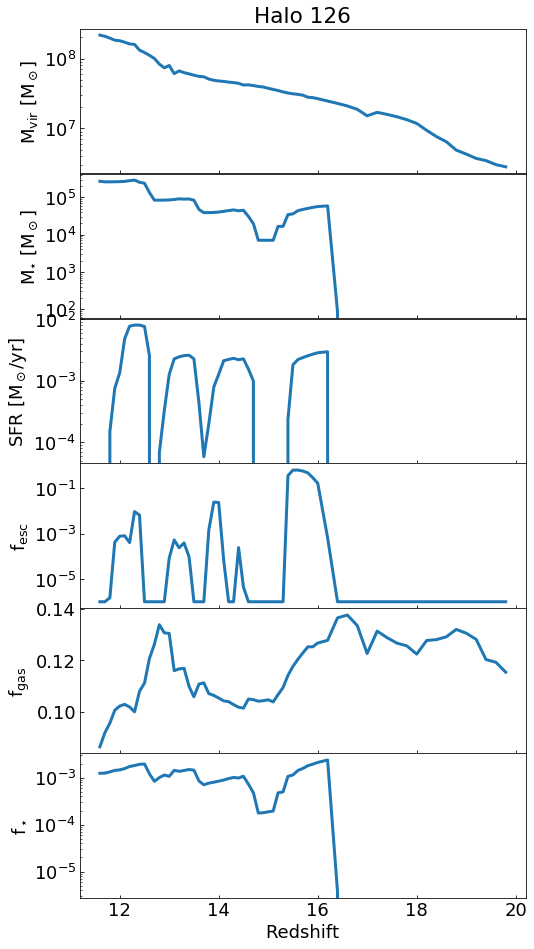

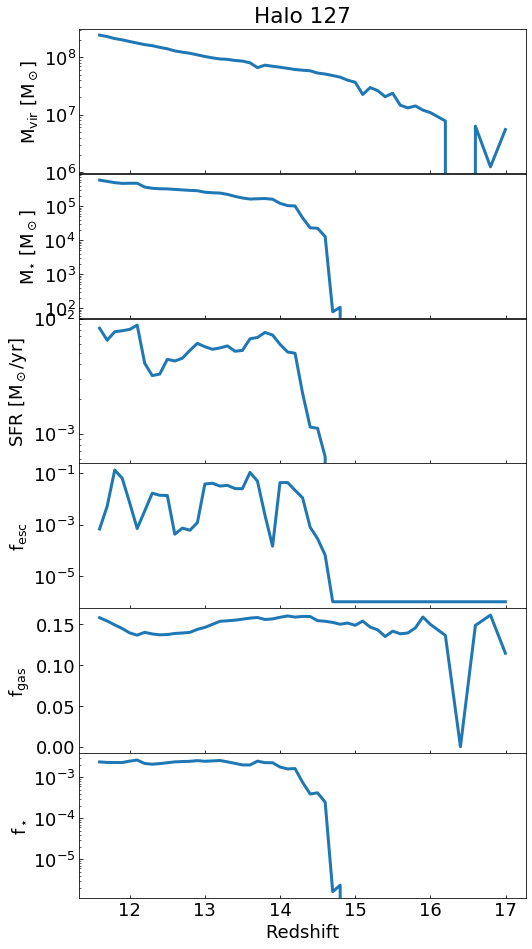

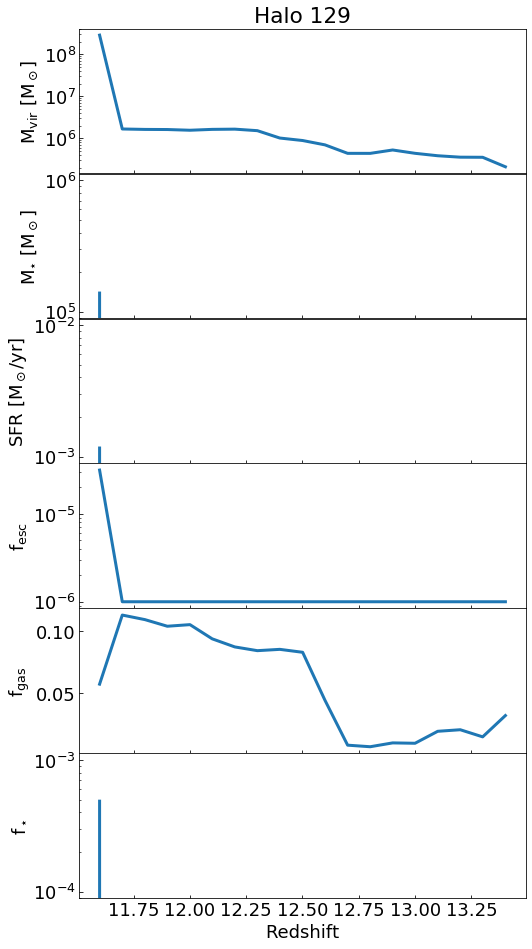

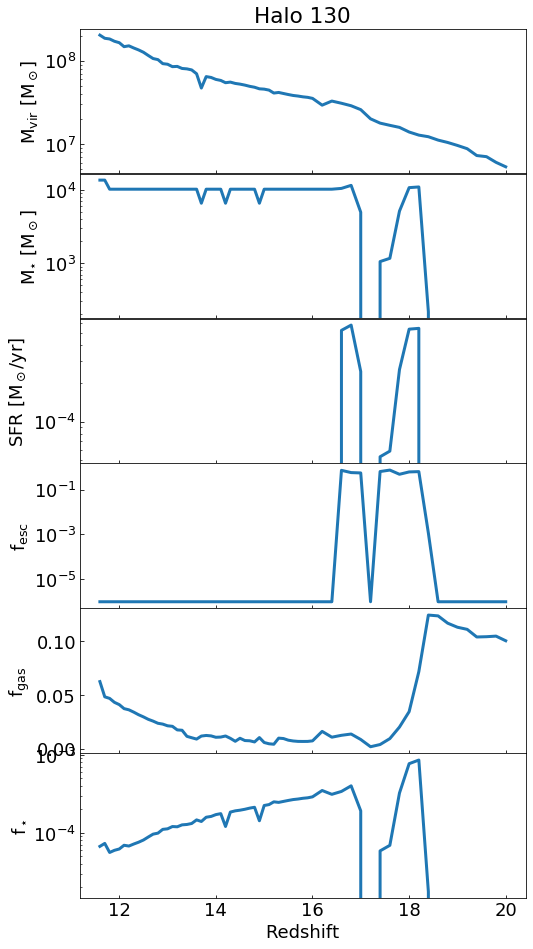

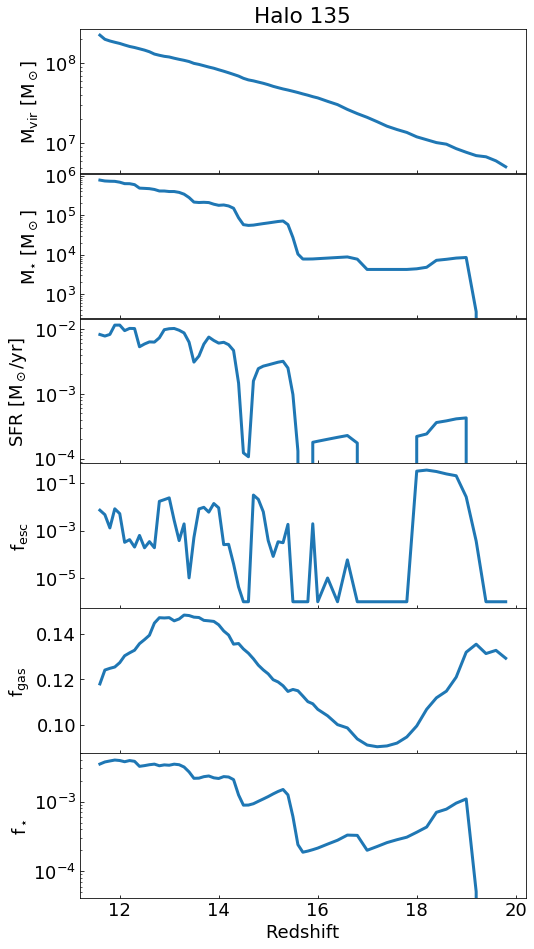

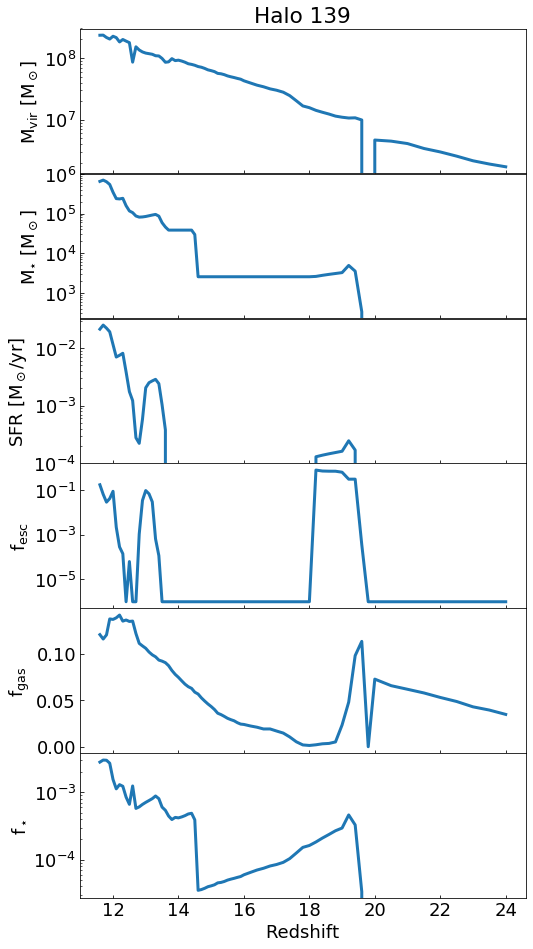

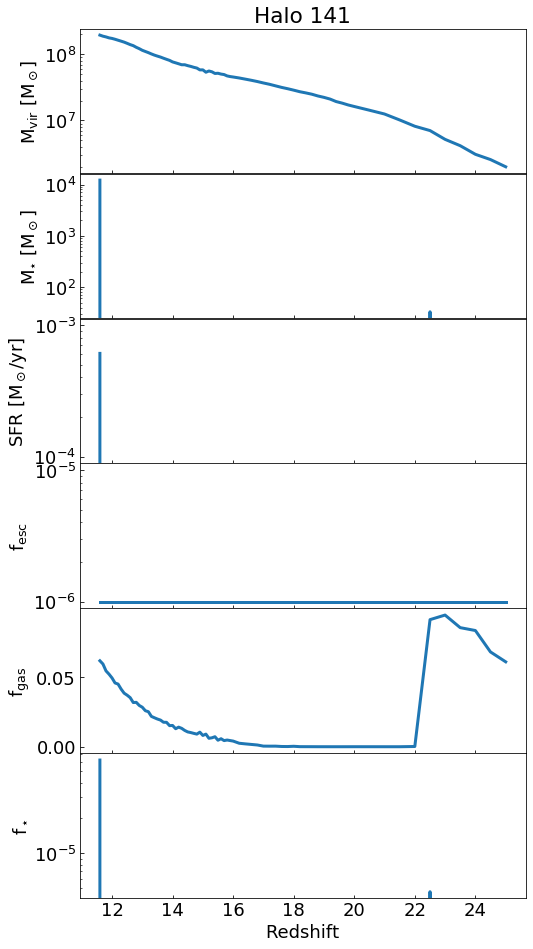

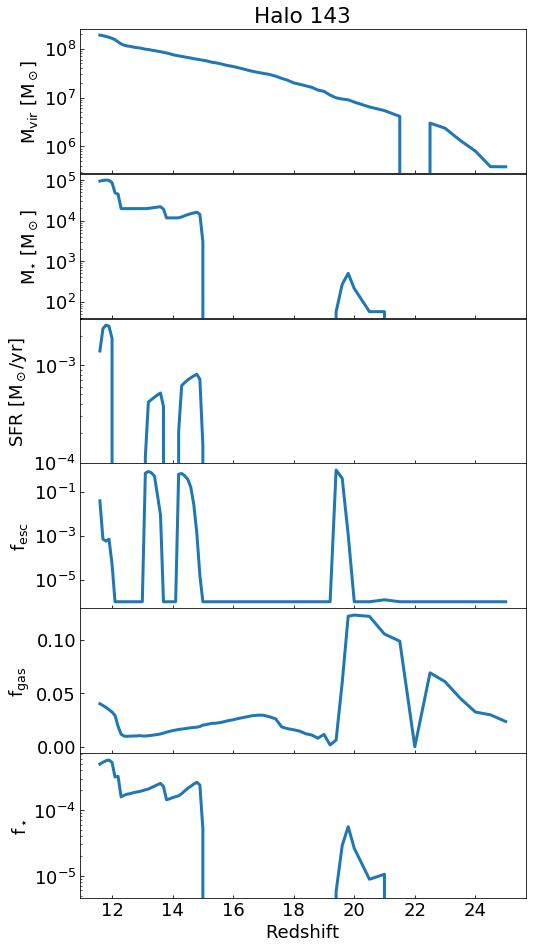

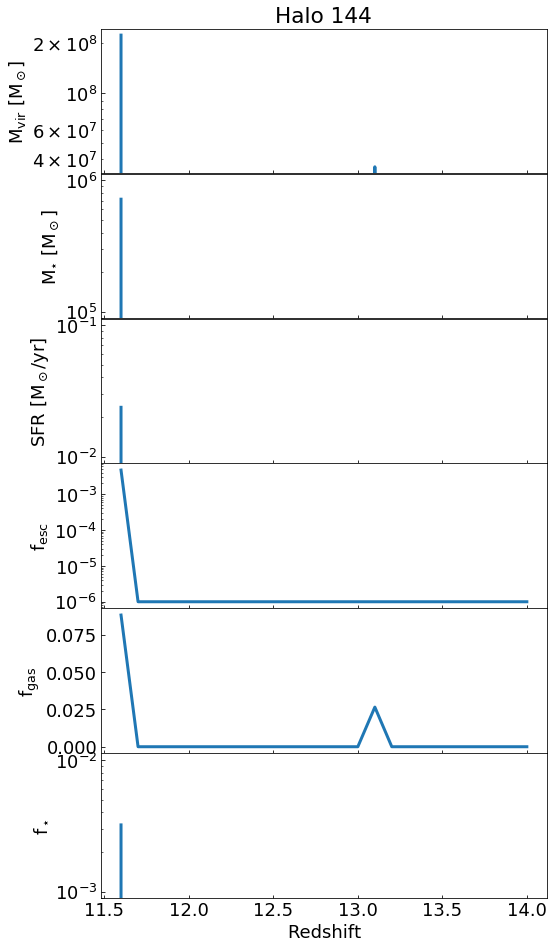

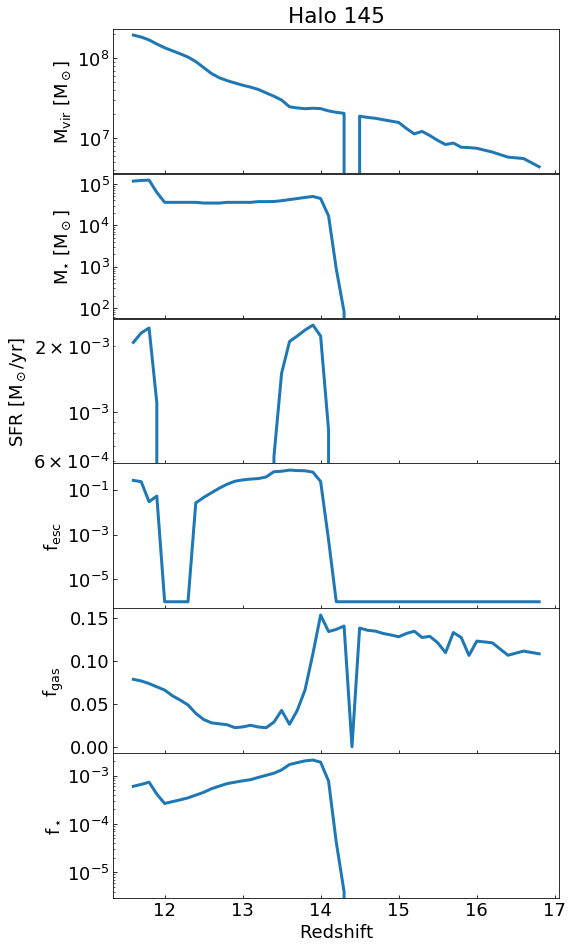

/usr/local/lib/python2.7/dist-packages/matplotlib/transforms.py:416: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


ValueError: cannot convert float NaN to integer

<Figure size 576x1152 with 6 Axes>

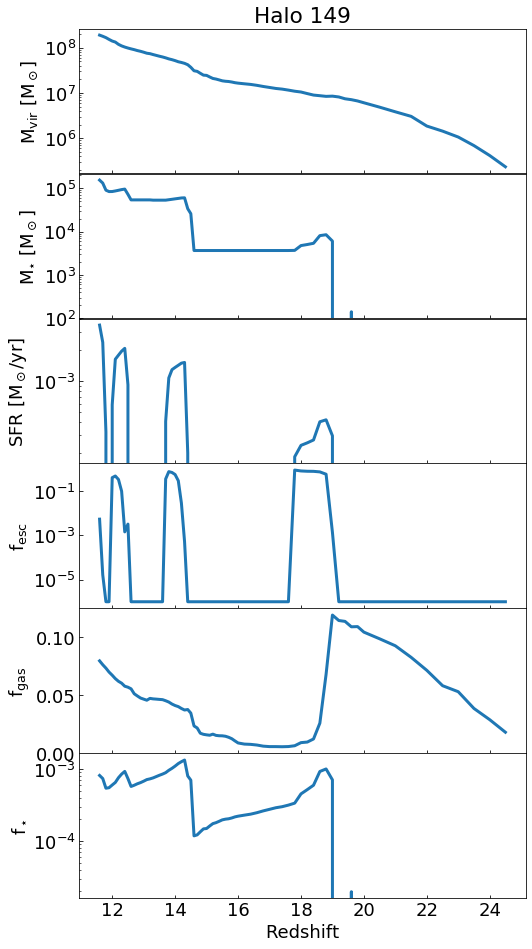

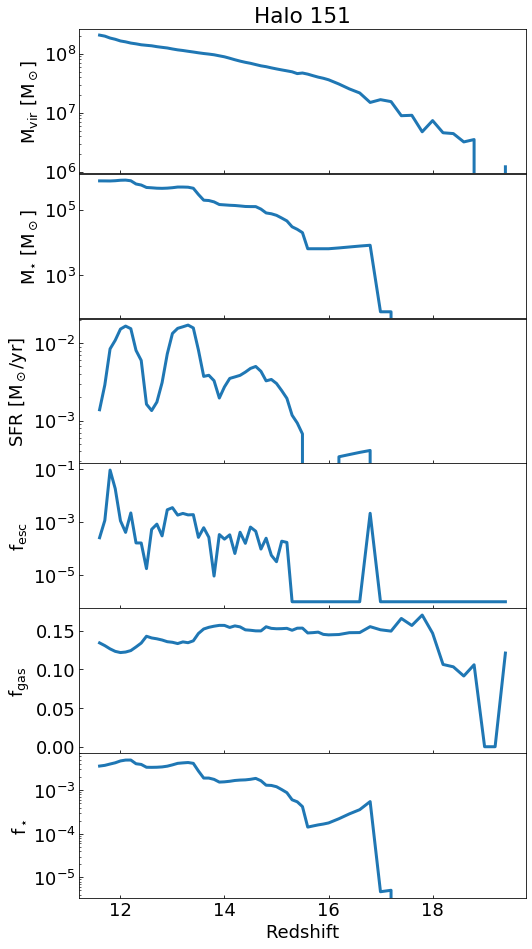

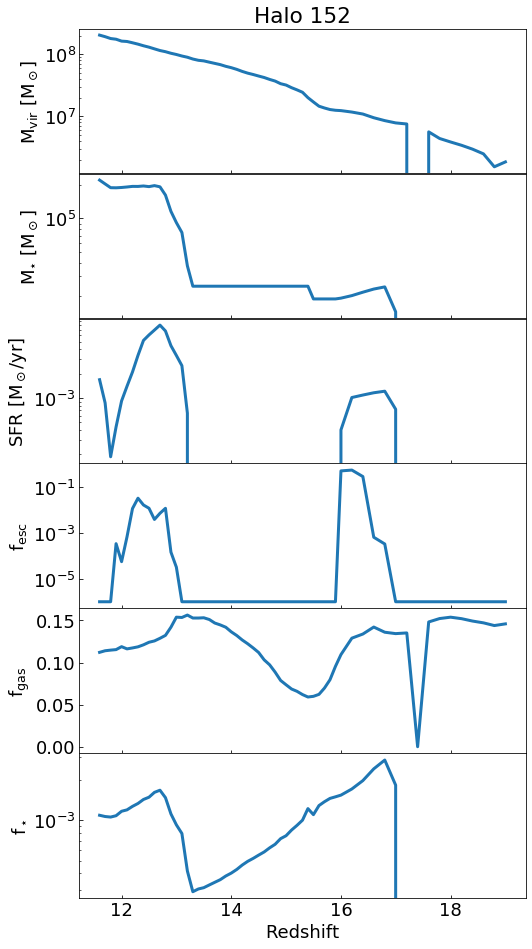

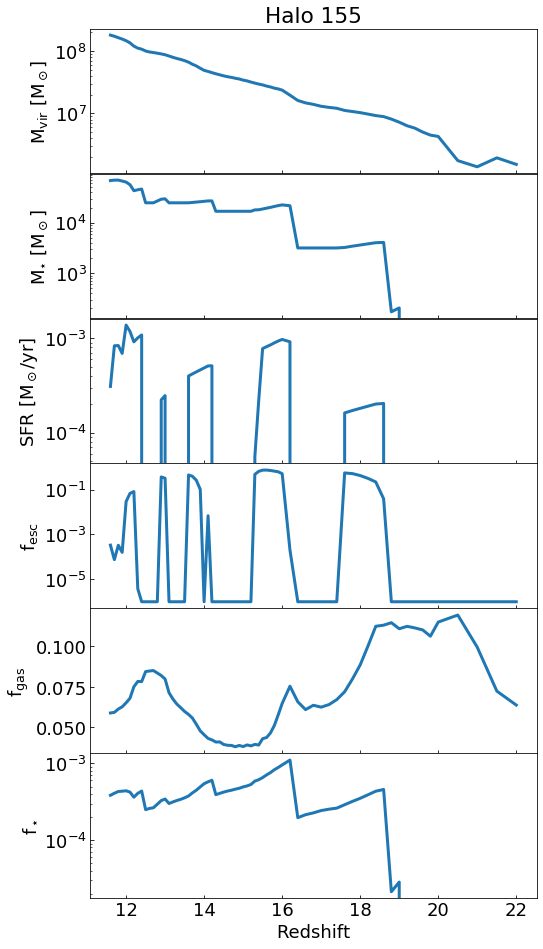

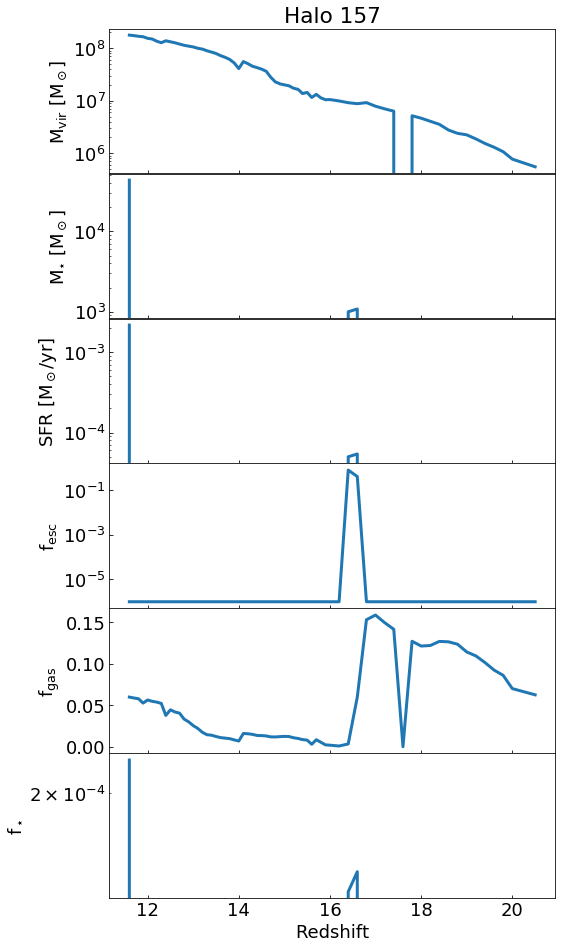

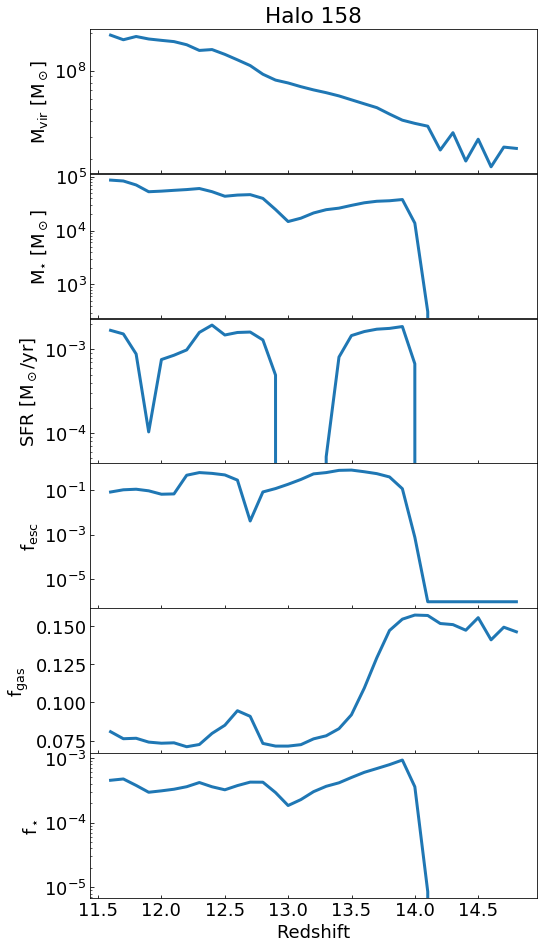

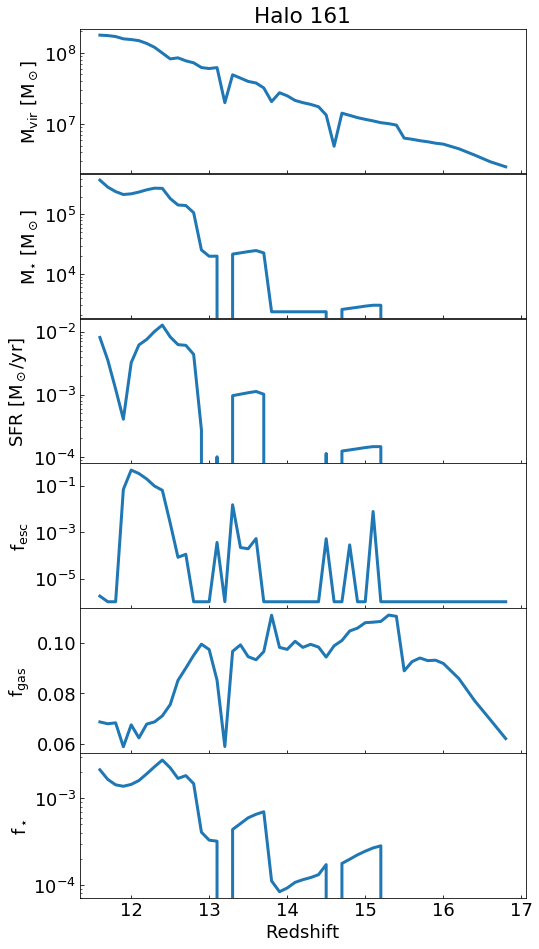

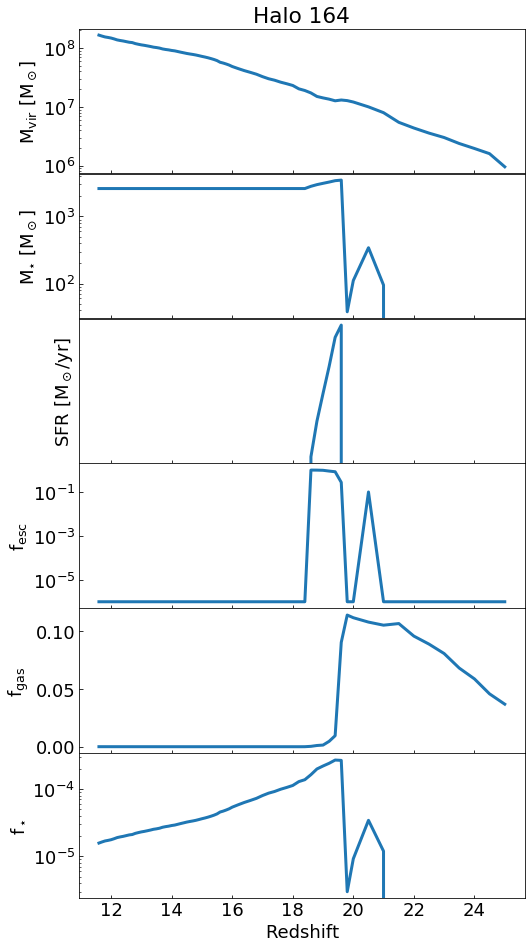

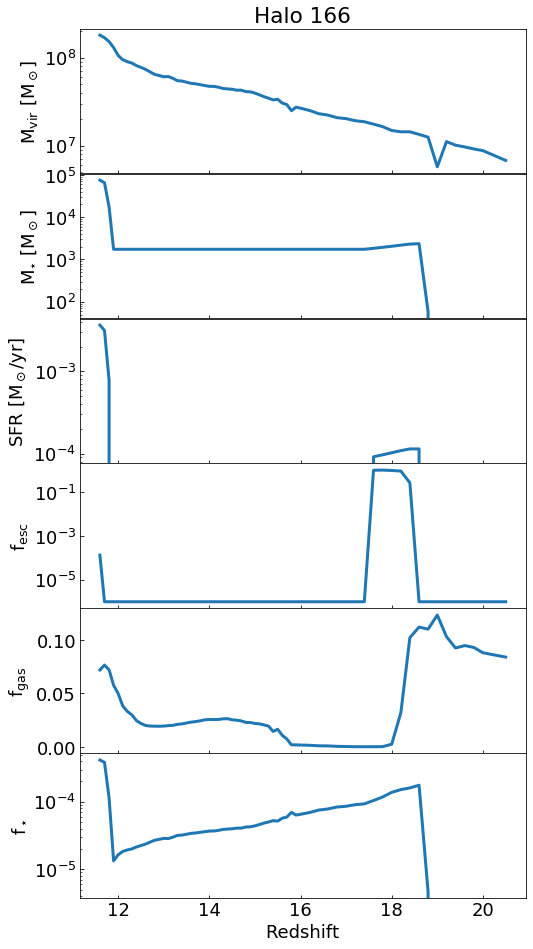

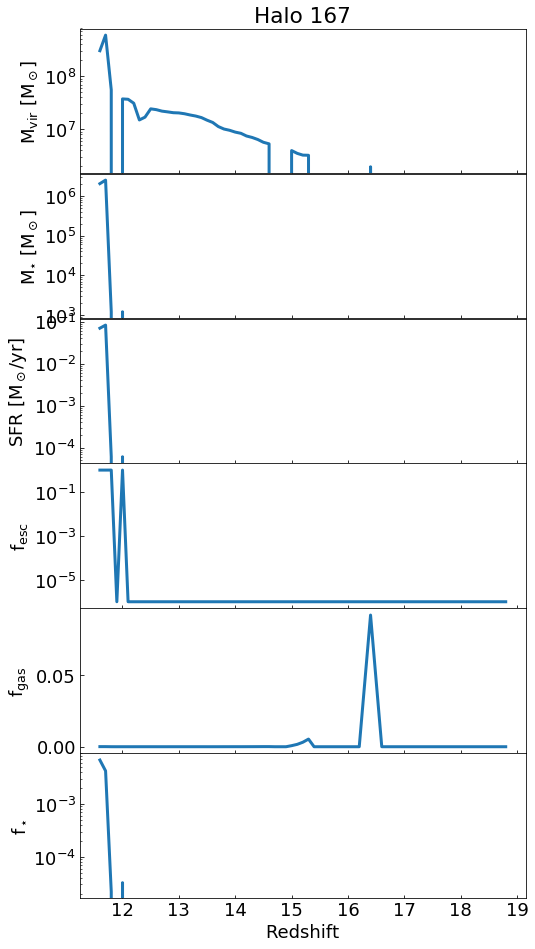

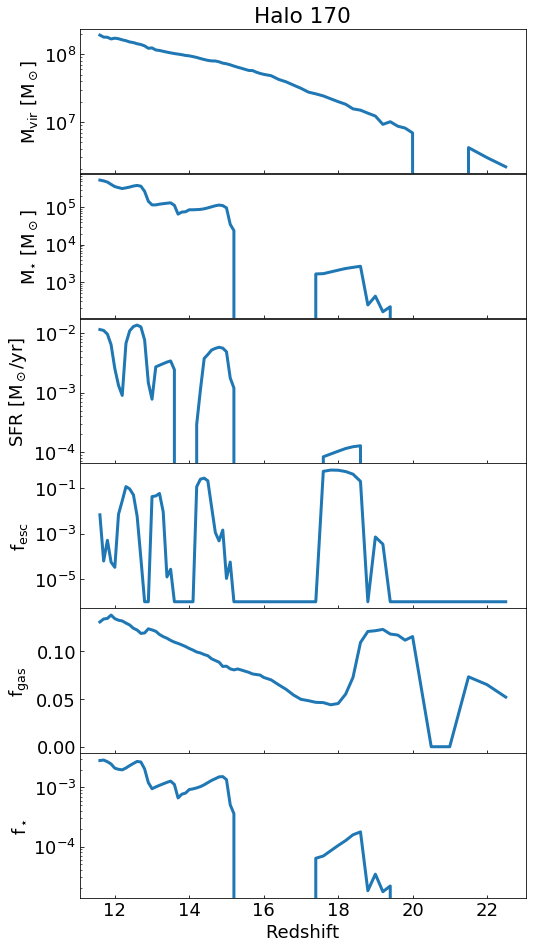

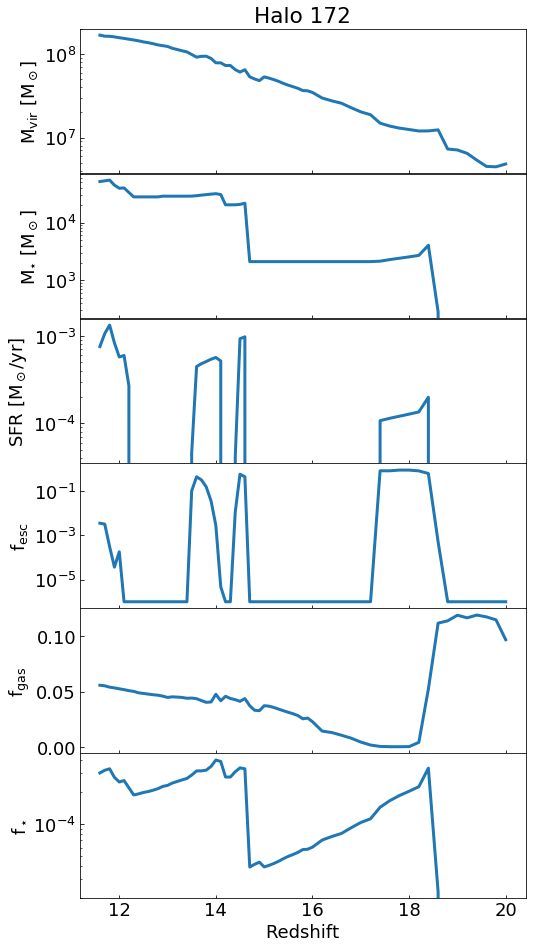

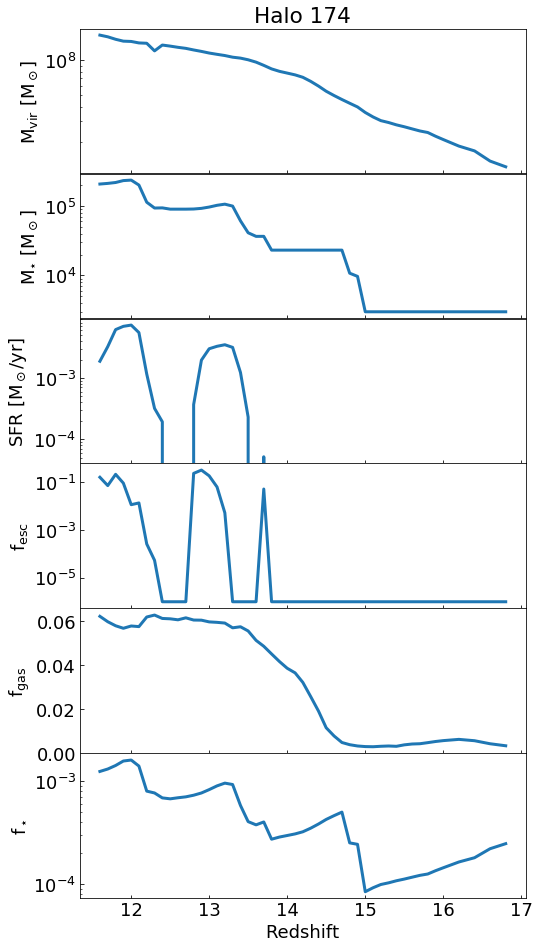

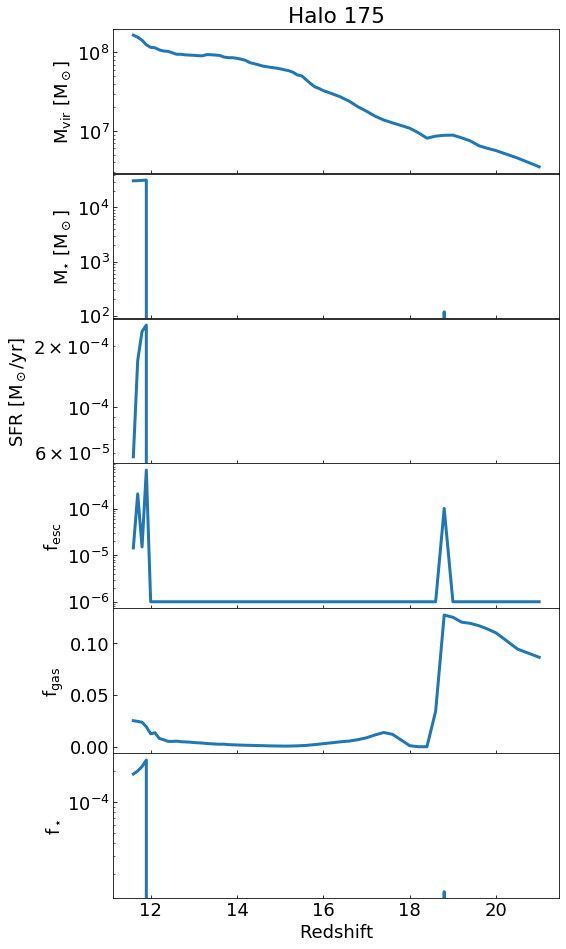

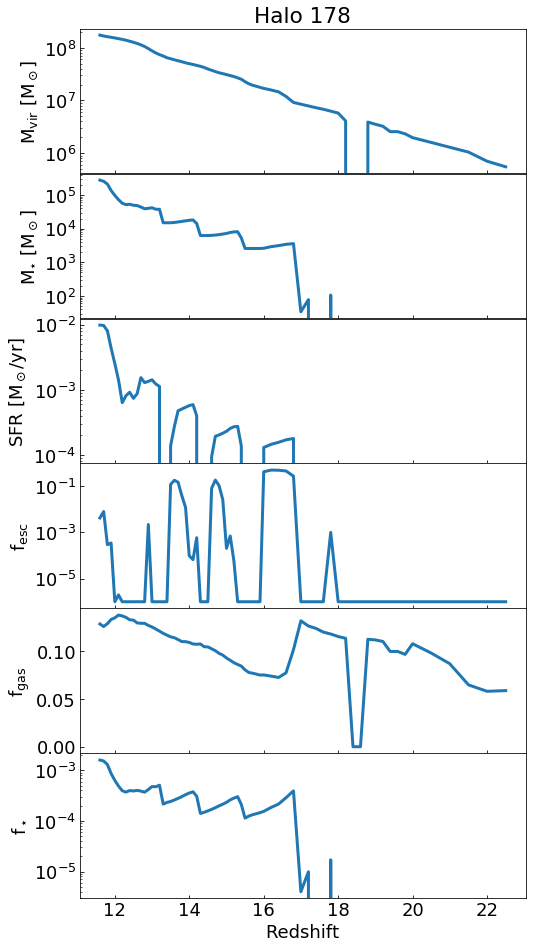

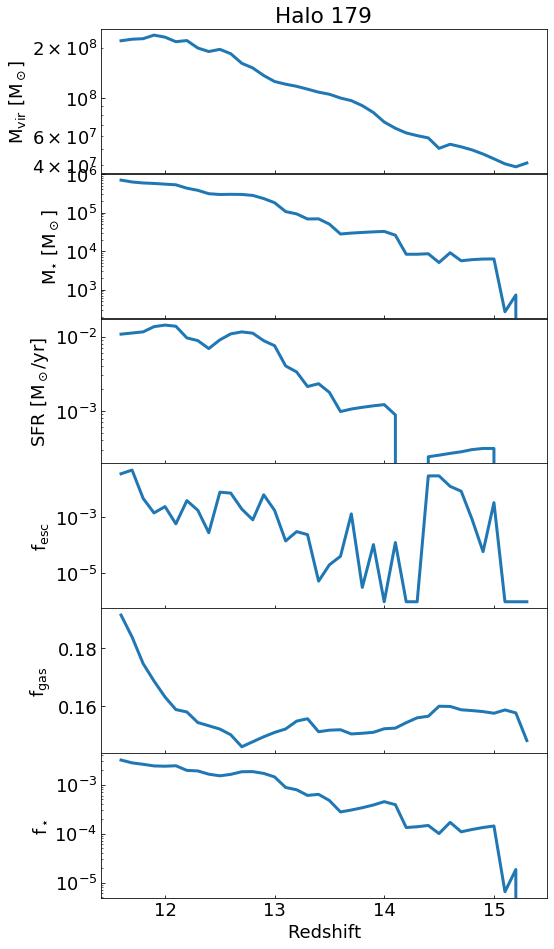

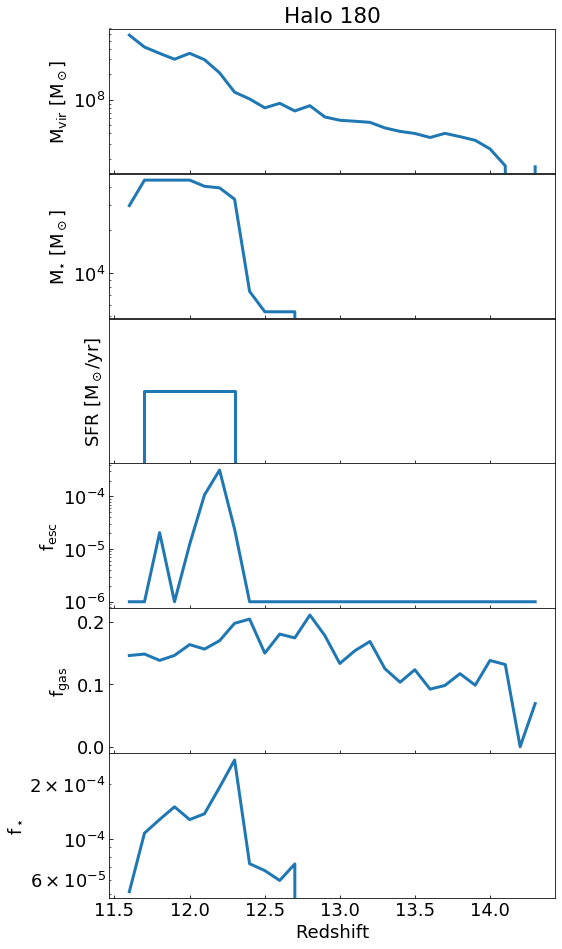

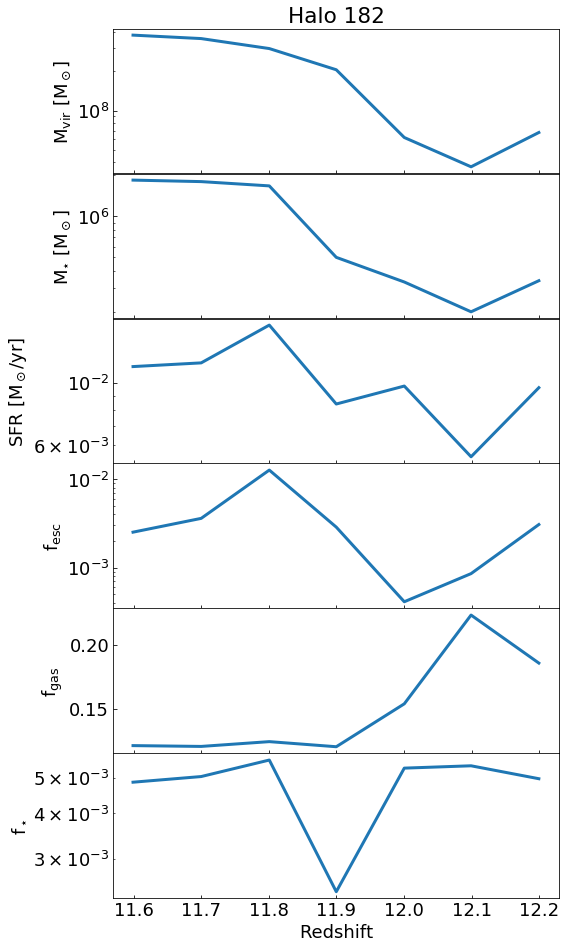

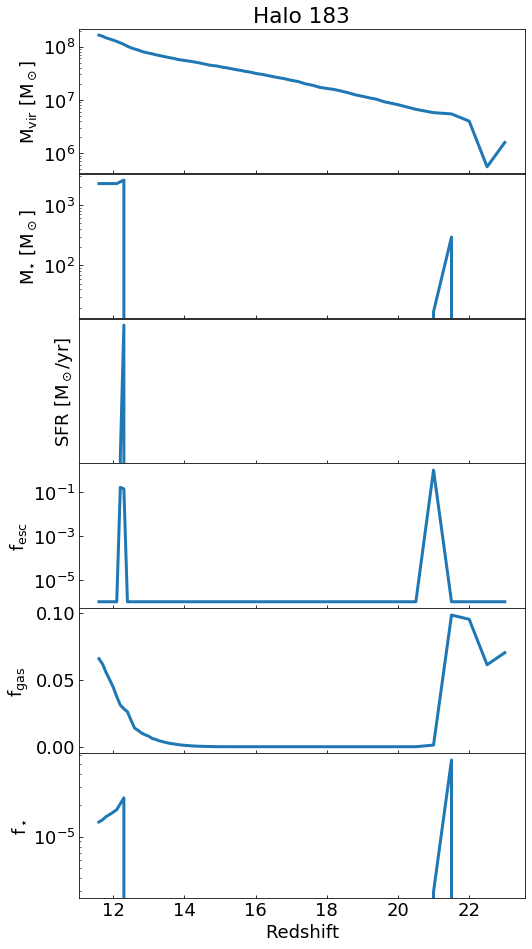

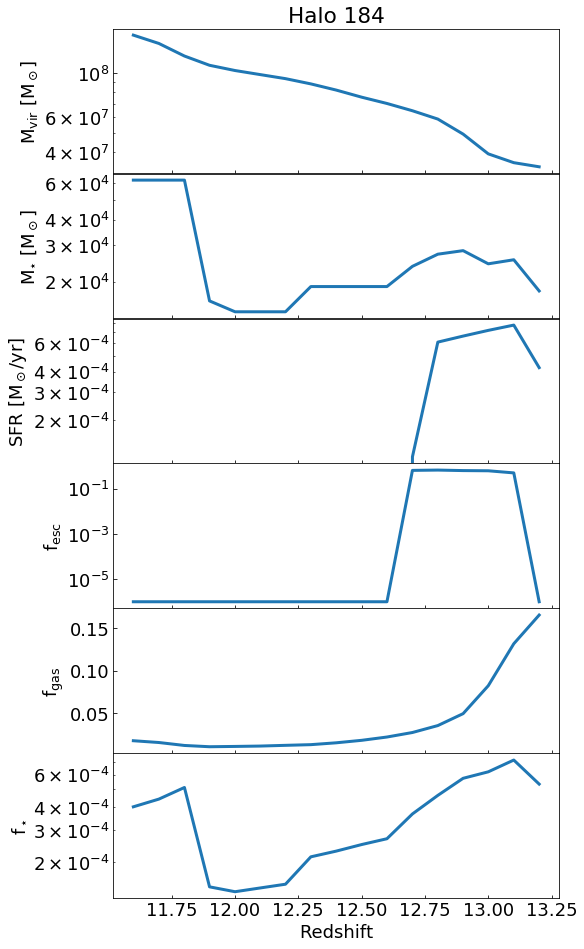

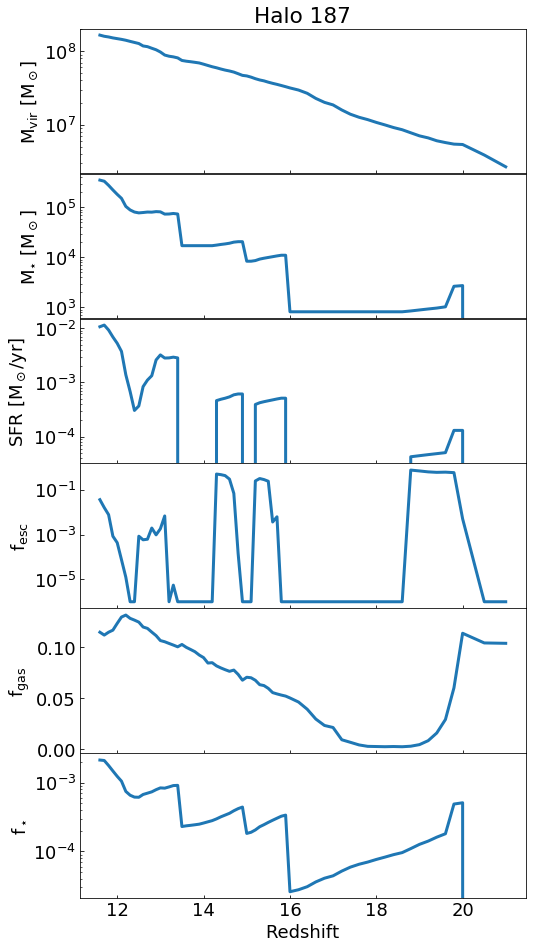

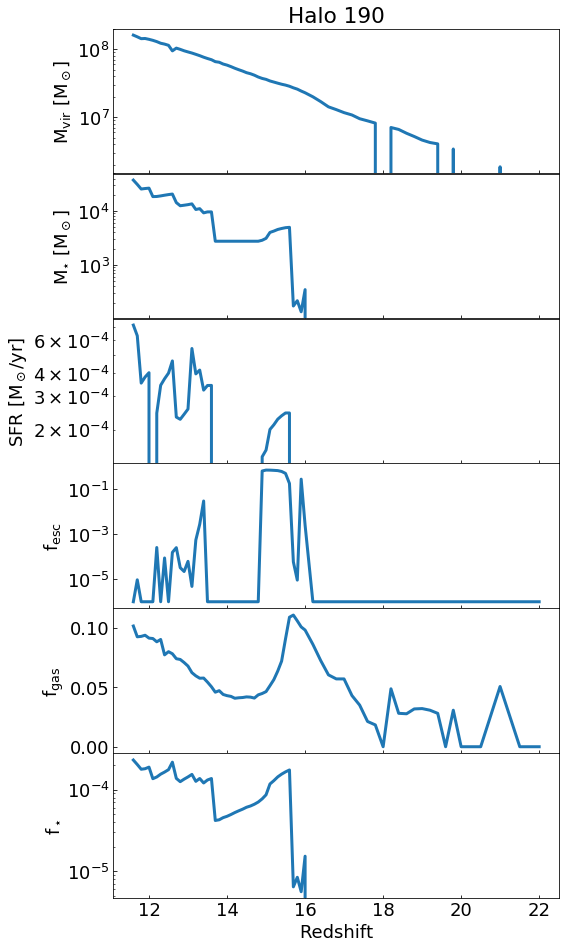

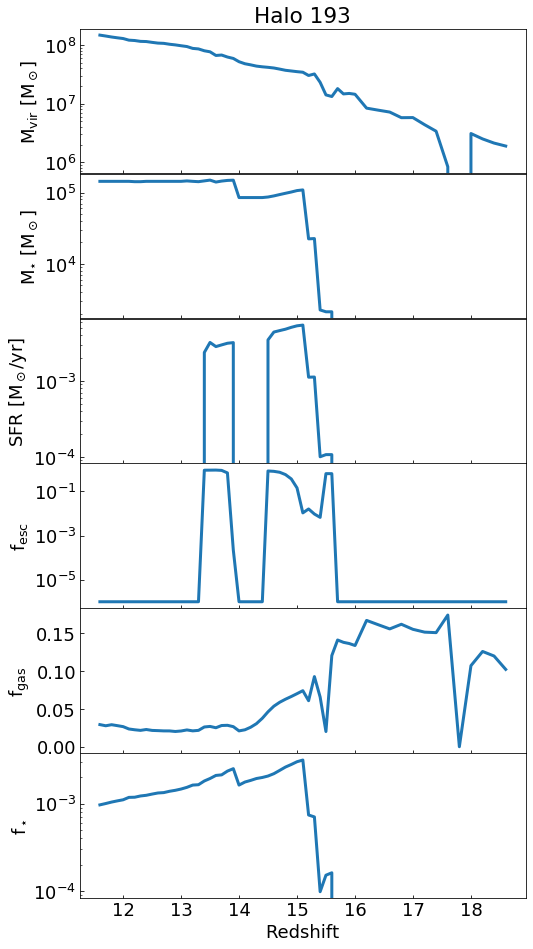

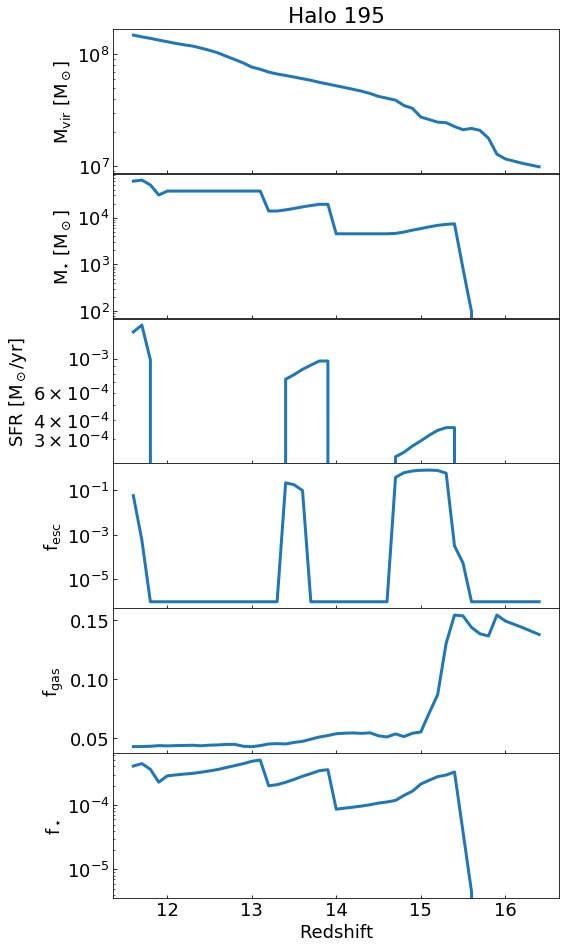

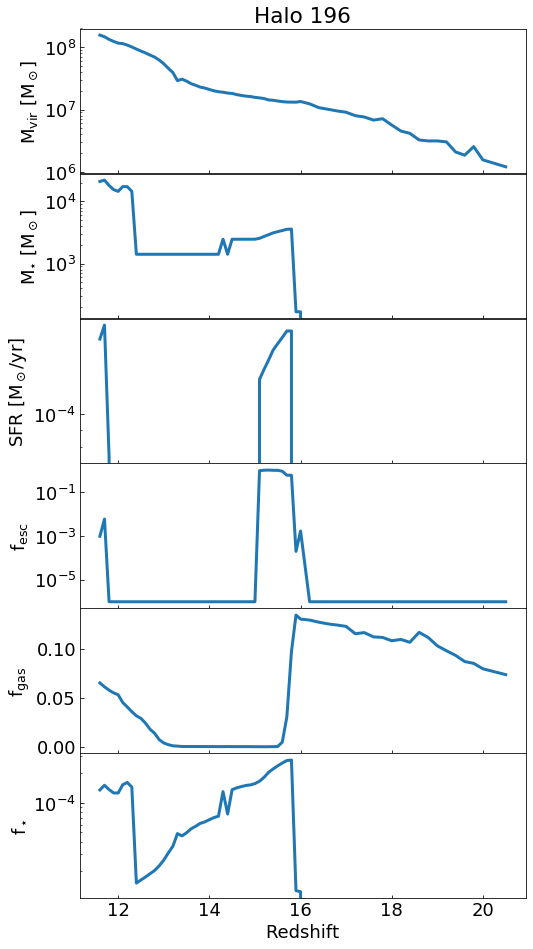

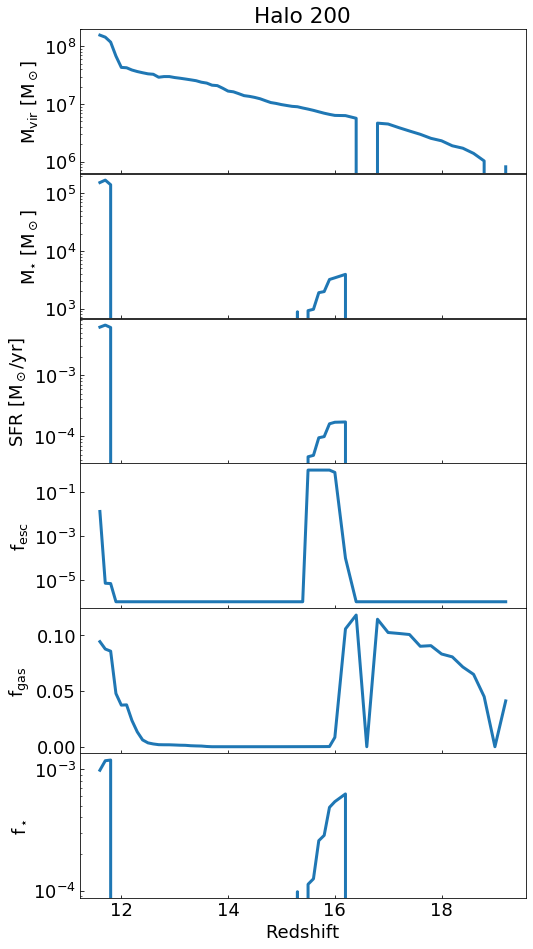

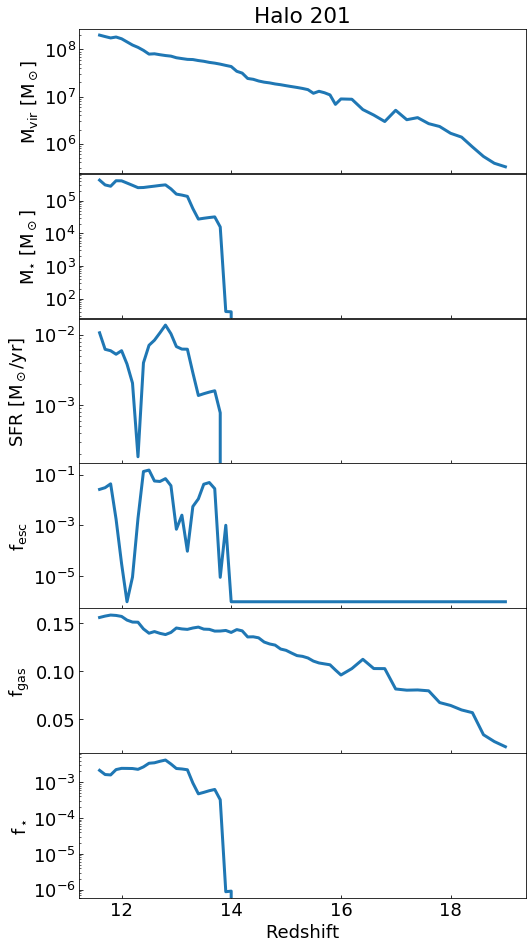

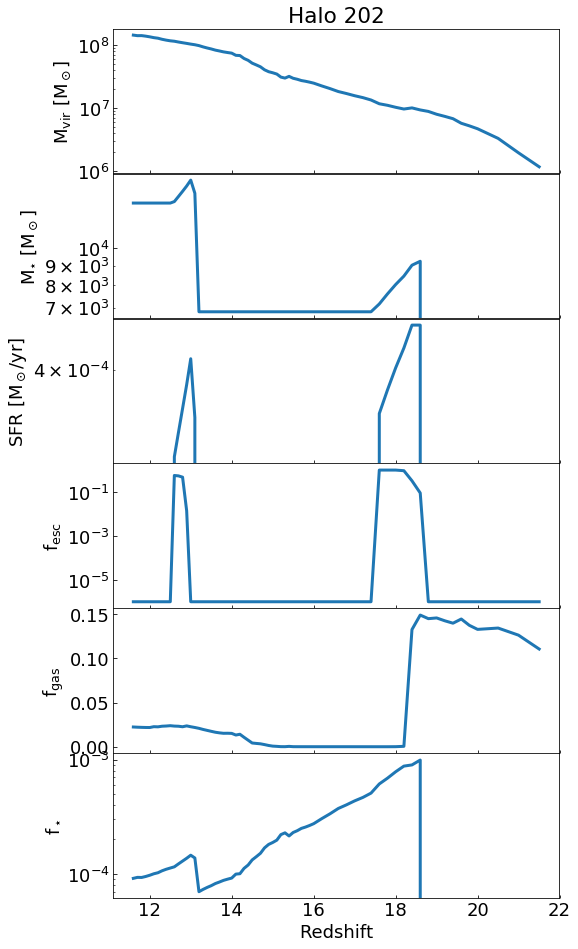

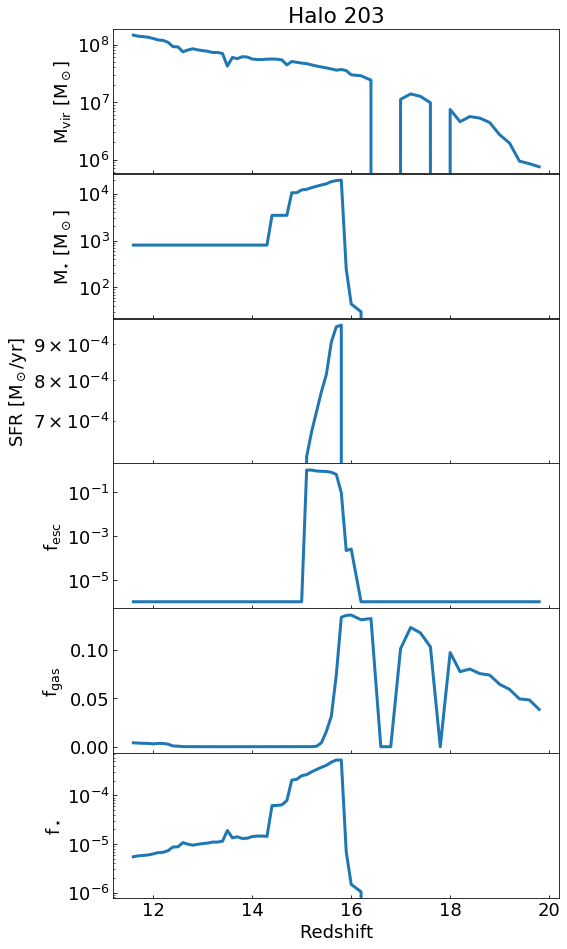

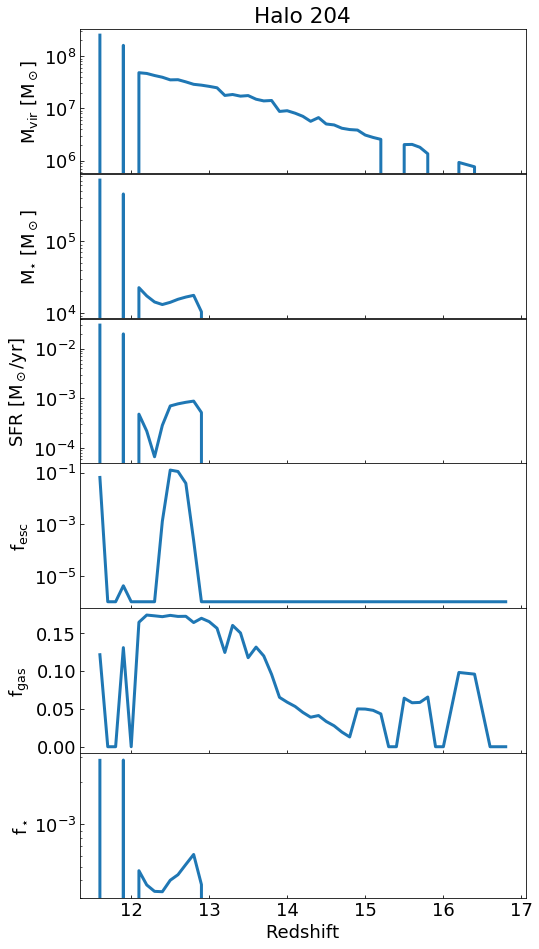

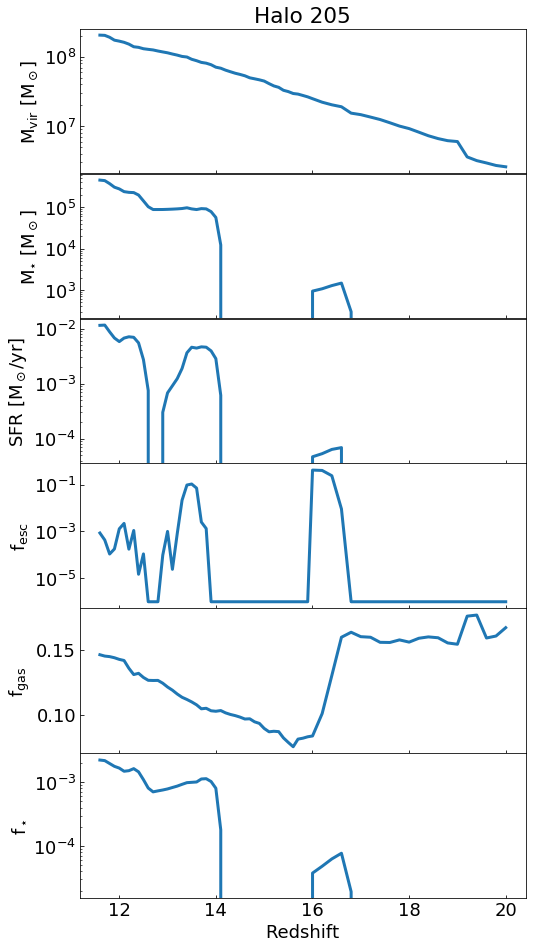

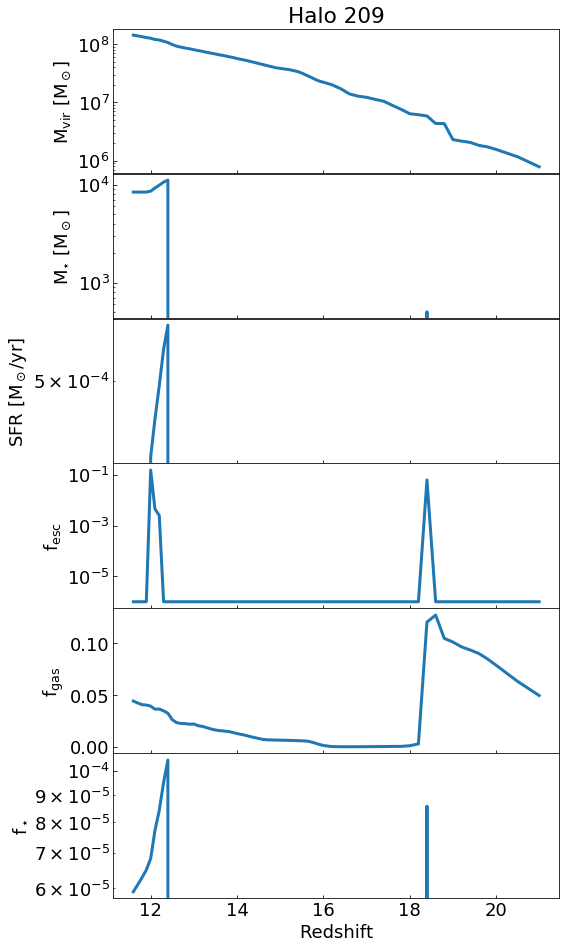

/usr/local/lib/python2.7/dist-packages/matplotlib/axis.py:1093: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


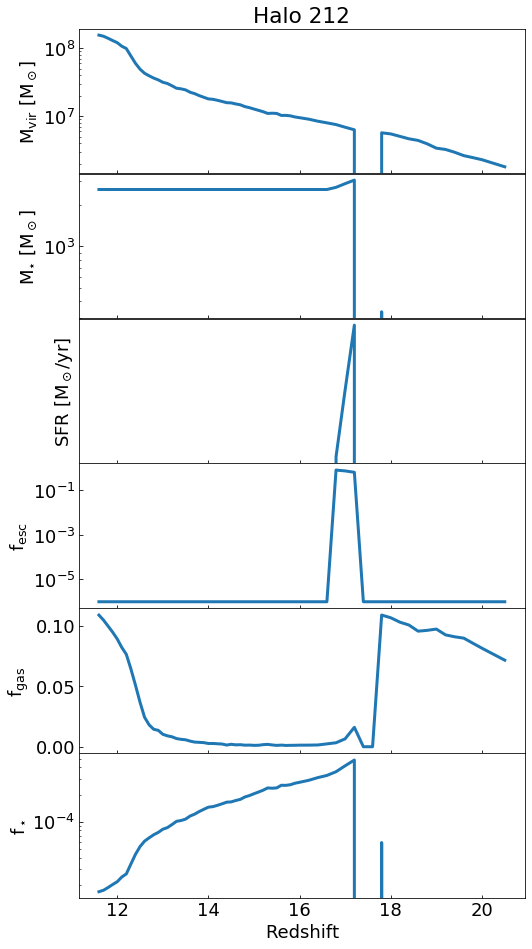

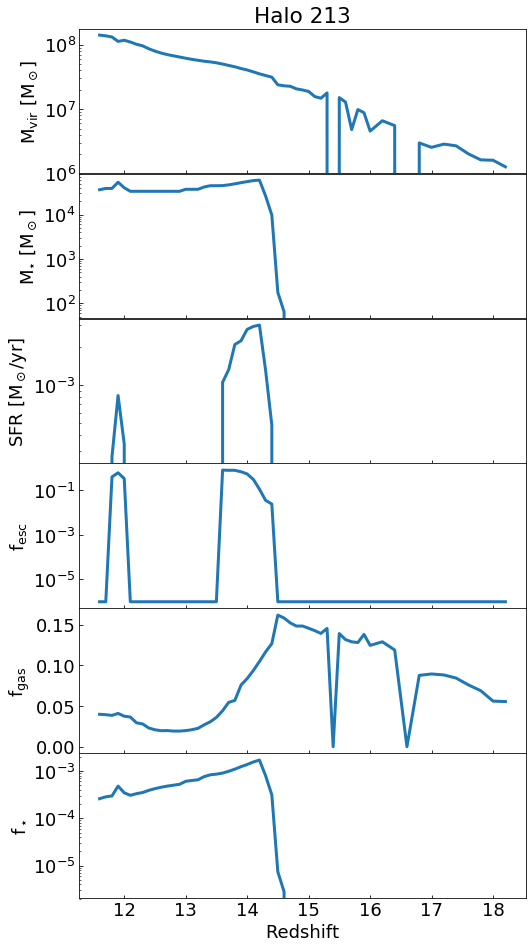

In [ ]:
fields = ['mass', 'Mstar', 'SFR', 'fesc', 'fgas', 'fstar']
log = [True, True, True, True, False, True]
ylabel = [r'M$_{\rm vir}$ [M$_\odot$]', r'M$_{\star}$ [M$_\odot$]', 'SFR [M$_\odot$/yr]',
          r'f$_{\rm esc}$', r'f$_{\rm gas}$', r'f$_\star$']
nhalos = len(halo_mmp)
for i in range(nhalos):
    if halo_mmp[i]['Mstar'][0] < 1: continue
    fig, ax = plt.subplots(6, 1, figsize=(8,16), sharex=True)
    plt.subplots_adjust(hspace=1e-3)
    for j in range(len(fields)):
        if log[j]:
            ax[j].semilogy(halo_mmp[i]['redshift'], halo_mmp[i][fields[j]], lw=3)
        else:
            ax[j].plot(halo_mmp[i]['redshift'], halo_mmp[i][fields[j]], lw=3)
        ax[j].set_ylabel(ylabel[j])
    ax[0].set_title('Halo %d' % (i))
    ax[-1].set_xlabel('Redshift')
    plt.savefig('halo%6.6d-evo.png' % (i))